### Import library

In [663]:
# display, transform, read, split ...
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt

# image processing
from tensorflow.keras.preprocessing import image


# Tensorflow
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image



from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf

from IPython.display import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

In [560]:
tf.__version__

'2.15.0'

## Train data pre-processing

#### Convert all images to .jpg and change all file name to sequential file name

Trained images were accquired from the internet by scraped technique. the name of imeages are random and not in order, and are not in same format.

For ease of processing, They will all be converted and changed name by creating function below.

Using picture_prep.ipynb to run pre-processing code

#### Prepare train data (image) to list of filename with directory

In [561]:
# Set up directories for train data
folder_path_amb = '../data/train_image/ambulance/'
files_amb = [f for f in os.listdir(folder_path_amb) if os.path.isfile(os.path.join(folder_path_amb, f))]

folder_path_cur = '../data/train_image/curtain/'
files_cur = [f for f in os.listdir(folder_path_cur) if os.path.isfile(os.path.join(folder_path_cur, f))]

# create a list of filenames
filenames_amb = []
for file in files_amb:
    filenames_amb.append(folder_path_amb+file)

filenames_cur = []
for file in files_cur:
    filenames_cur.append(folder_path_cur+file)



# Make a dataframe based on the filenames
df1 = pd.DataFrame(filenames_amb, columns = ["filename"])
df2 = pd.DataFrame(filenames_cur, columns = ["filename"])


# Add Class columns
df1['class'] = pd.Series([0 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)



# Split into train and validation sets
train_set_percentage = .9


train_df1 = df1[:int(len(df1)*train_set_percentage)]
val_df1 = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]



df_new_train = pd.concat([train_df1, train_df2])
df_new_val = pd.concat([val_df1, val_df2])

# shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [562]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

#### Create pipeline for train data loading and resize to 224x224

In [563]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  #image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [564]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [565]:
batch_size = 8
# Train data
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(25)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# Validation data
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(3)
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

## Modeling

#### The model will be train on VGG16 pre-trained model

In [566]:
# Call VGG16
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [567]:
# add train layers to model
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

#x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [568]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [569]:
# freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_28
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [570]:
# Check if train and freeze layers
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_28
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_29
True
dense_58
True
dense_59
True


In [571]:
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [572]:
# opt = tf.train.AdamOptimizer(learning_rate = 0.001)

opt = tf.keras.optimizers.Adam('learning_rate'==0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [573]:
train_steps = int(13) #total trains set / batch_size
val_steps = int(3)
epochs = 5

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 13
val steps: 3


In [574]:
# # # Train the model with validation
history = model.fit( train_dataset,
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/5


13/13 [==============================] - 16s 1s/step - loss: 2.5937 - accuracy: 0.5385 - val_loss: 0.5836 - val_accuracy: 0.6667
Epoch 2/5
13/13 [==============================] - 20s 2s/step - loss: 2.2997 - accuracy: 0.5577 - val_loss: 0.5836 - val_accuracy: 0.6667
Epoch 3/5
13/13 [==============================] - 20s 2s/step - loss: 2.5377 - accuracy: 0.5481 - val_loss: 0.5836 - val_accuracy: 0.6667
Epoch 4/5
13/13 [==============================] - 21s 2s/step - loss: 2.2966 - accuracy: 0.5577 - val_loss: 0.5836 - val_accuracy: 0.6667
Epoch 5/5
13/13 [==============================] - 20s 2s/step - loss: 2.5402 - accuracy: 0.5481 - val_loss: 0.5836 - val_accuracy: 0.6667


In [575]:
# Score
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 4s 1s/step - loss: 0.5836 - accuracy: 0.6667
model accuracy: 0.6666666865348816


## Test first model

Sample of test image 1:


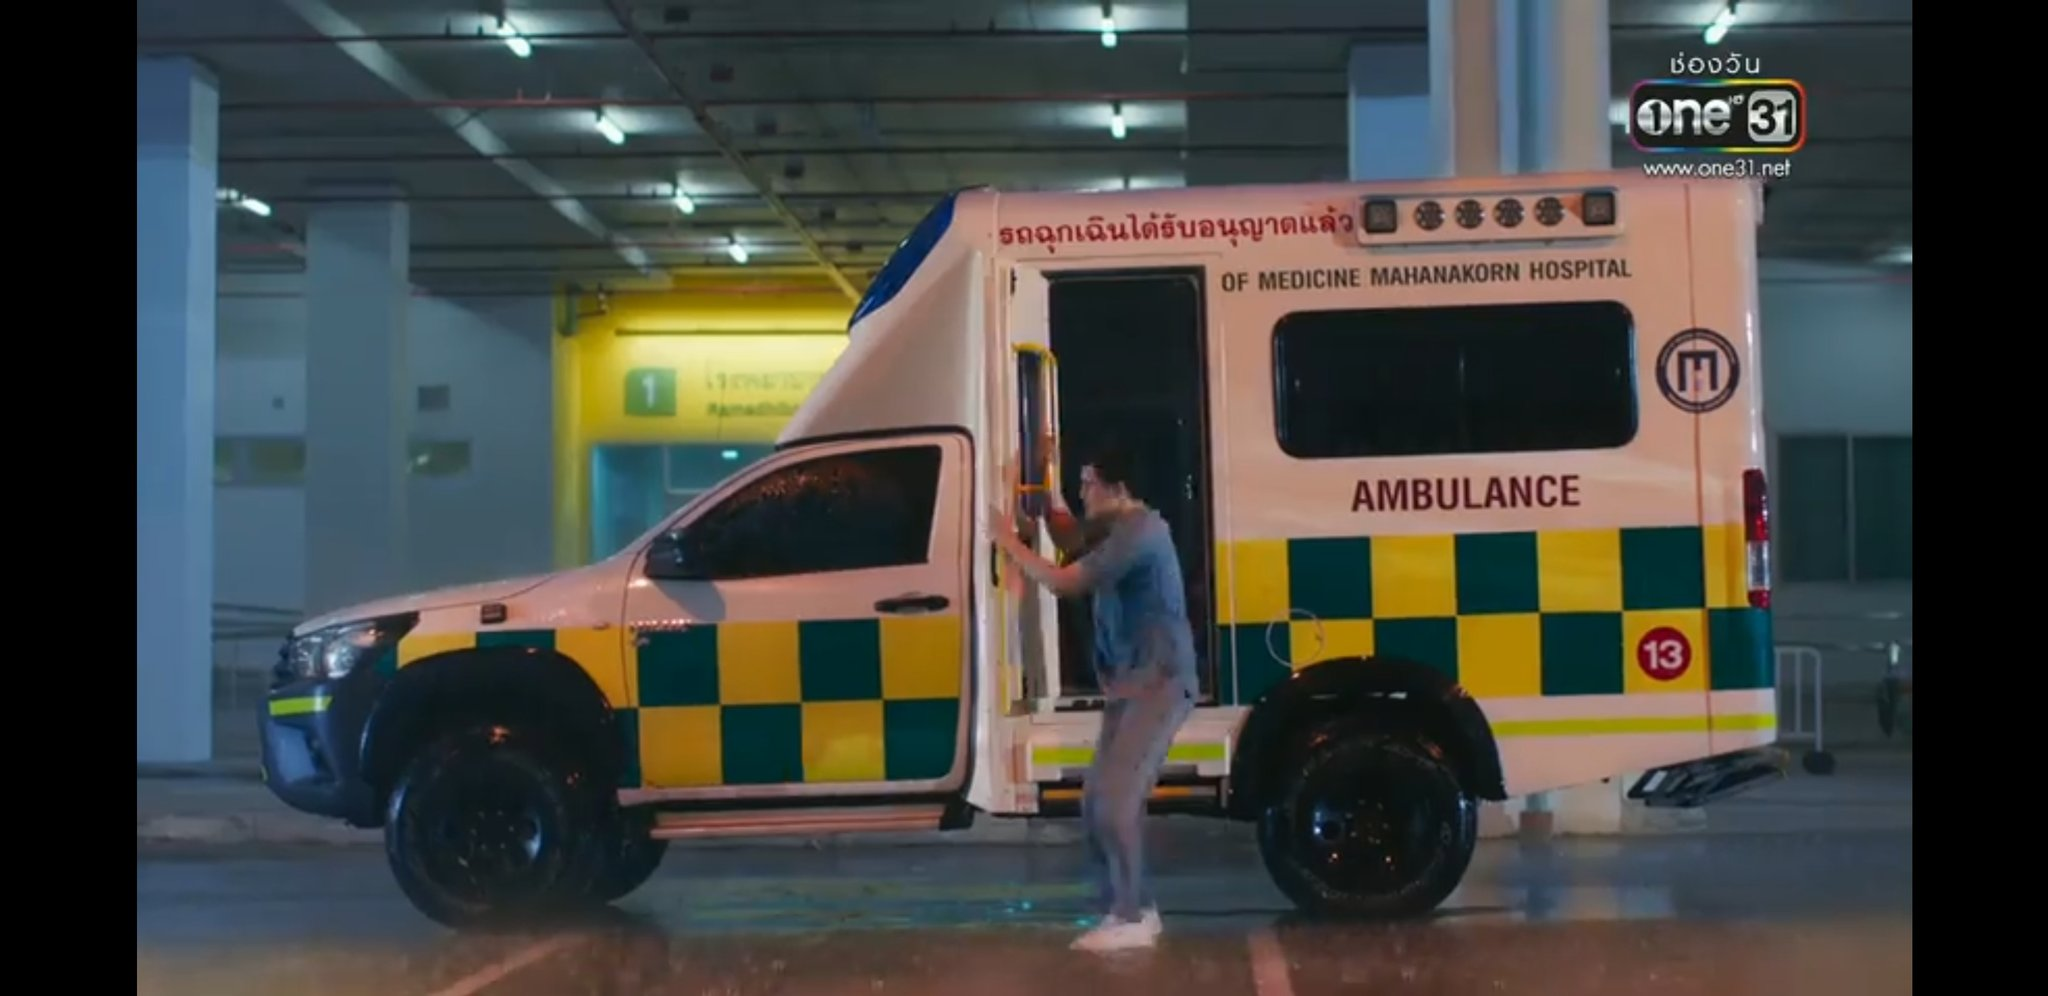

In [576]:
# Call test image for prediction
image_test_1 = '../data/test_image/1_amb.jpg'
image_test_2 = '../data/test_image/2_curtain.jpg'
image_test_3 = '../data/test_image/3_none.jpg'
image_test_4 = '../data/test_image/4_lisa.jpg'
filenames_test = [image_test_1, image_test_2, image_test_3, image_test_4]
print("Sample of test image 1:")
Image(image_test_1)

In [577]:
# Create list of file to run test
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [578]:
# Predict
preds = []
for x in x_test:
    preds.append(model.predict(x))

# Display result

for i in range(len(filenames_test)):
    print(filenames_test[i])
    if preds[i][0][0] > 0.9:
        print("It's an ambulance")
    else:
        print("None of them")


1/1 [==============================] - 0s 238ms/step
../data/test_image/1_amb.jpg
None of them
../data/test_image/2_curtain.jpg
None of them
../data/test_image/3_none.jpg
None of them
../data/test_image/4_lisa.jpg
None of them


### Accuracy and actual prediction isn't satisfy

-----

## Model improvement

### Consider expand the train dataset (and validation)

### Image augmentation

The selected image may appear in video in different angle, therefore the trained image should be in multiple angle and size
Using picture_prep.ipynb to run pre-processing code


Now, the data is 10 times larger due to augmentation of image. Let's feed these data to model and try again

In [616]:
# Set up directories for train data
folder_path_amb = '../data/train_image/augmented/ambulance/'
files_amb = [f for f in os.listdir(folder_path_amb) if os.path.isfile(os.path.join(folder_path_amb, f))]

folder_path_cur = '../data/train_image/augmented/curtain/'
files_cur = [f for f in os.listdir(folder_path_cur) if os.path.isfile(os.path.join(folder_path_cur, f))]

# create a list of filenames
filenames_amb = []
for file in files_amb:
    filenames_amb.append(folder_path_amb+file)

filenames_cur = []
for file in files_cur:
    filenames_cur.append(folder_path_cur+file)



# Make a dataframe based on the filenames
df1 = pd.DataFrame(filenames_amb, columns = ["filename"])
df2 = pd.DataFrame(filenames_cur, columns = ["filename"])


# Add Class columns
df1['class'] = pd.Series([0 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)



# Split into train and validation sets
train_set_percentage = .9


train_df1 = df1[:int(len(df1)*train_set_percentage)]
val_df1 = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]



df_new_train = pd.concat([train_df1, train_df2])
df_new_val = pd.concat([val_df1, val_df2])

# shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

batch_size = 8
# Train data
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(32)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# Validation data
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(3)
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

Re-compile the model for training

In [617]:
# Call VGG16
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

# add train layers to model
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x) #Adaptive Pooling

# Add a fully-connected layer
x = Dense(512, activation='relu')(x)

#x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model_2 = Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model_2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [618]:
# opt = tf.train.AdamOptimizer(learning_rate = 0.001)

opt = tf.keras.optimizers.Adam('learning_rate'==0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model_2.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [622]:
train_steps = int(33) #total trains set / batch_size
val_steps = int(3)
epochs = 10

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 33
val steps: 3


Use new dataset to train the existing model

In [623]:
# # # Train the model with validation
history = model_2.fit( train_dataset,
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/5


33/33 [==============================] - 41s 1s/step - loss: 1.0974 - accuracy: 0.7386
Epoch 2/5
33/33 [==============================] - 40s 1s/step - loss: 1.0537 - accuracy: 0.7424
Epoch 3/5
33/33 [==============================] - 41s 1s/step - loss: 1.0648 - accuracy: 0.7386
Epoch 4/5
33/33 [==============================] - 40s 1s/step - loss: 1.0640 - accuracy: 0.7386
Epoch 5/5
33/33 [==============================] - 40s 1s/step - loss: 1.1045 - accuracy: 0.7386


3/3 [==============================] - 2s 748ms/step
../data/train_image/augmented/curtain/7Flip1_augmentedCrop1_augmented.jpg


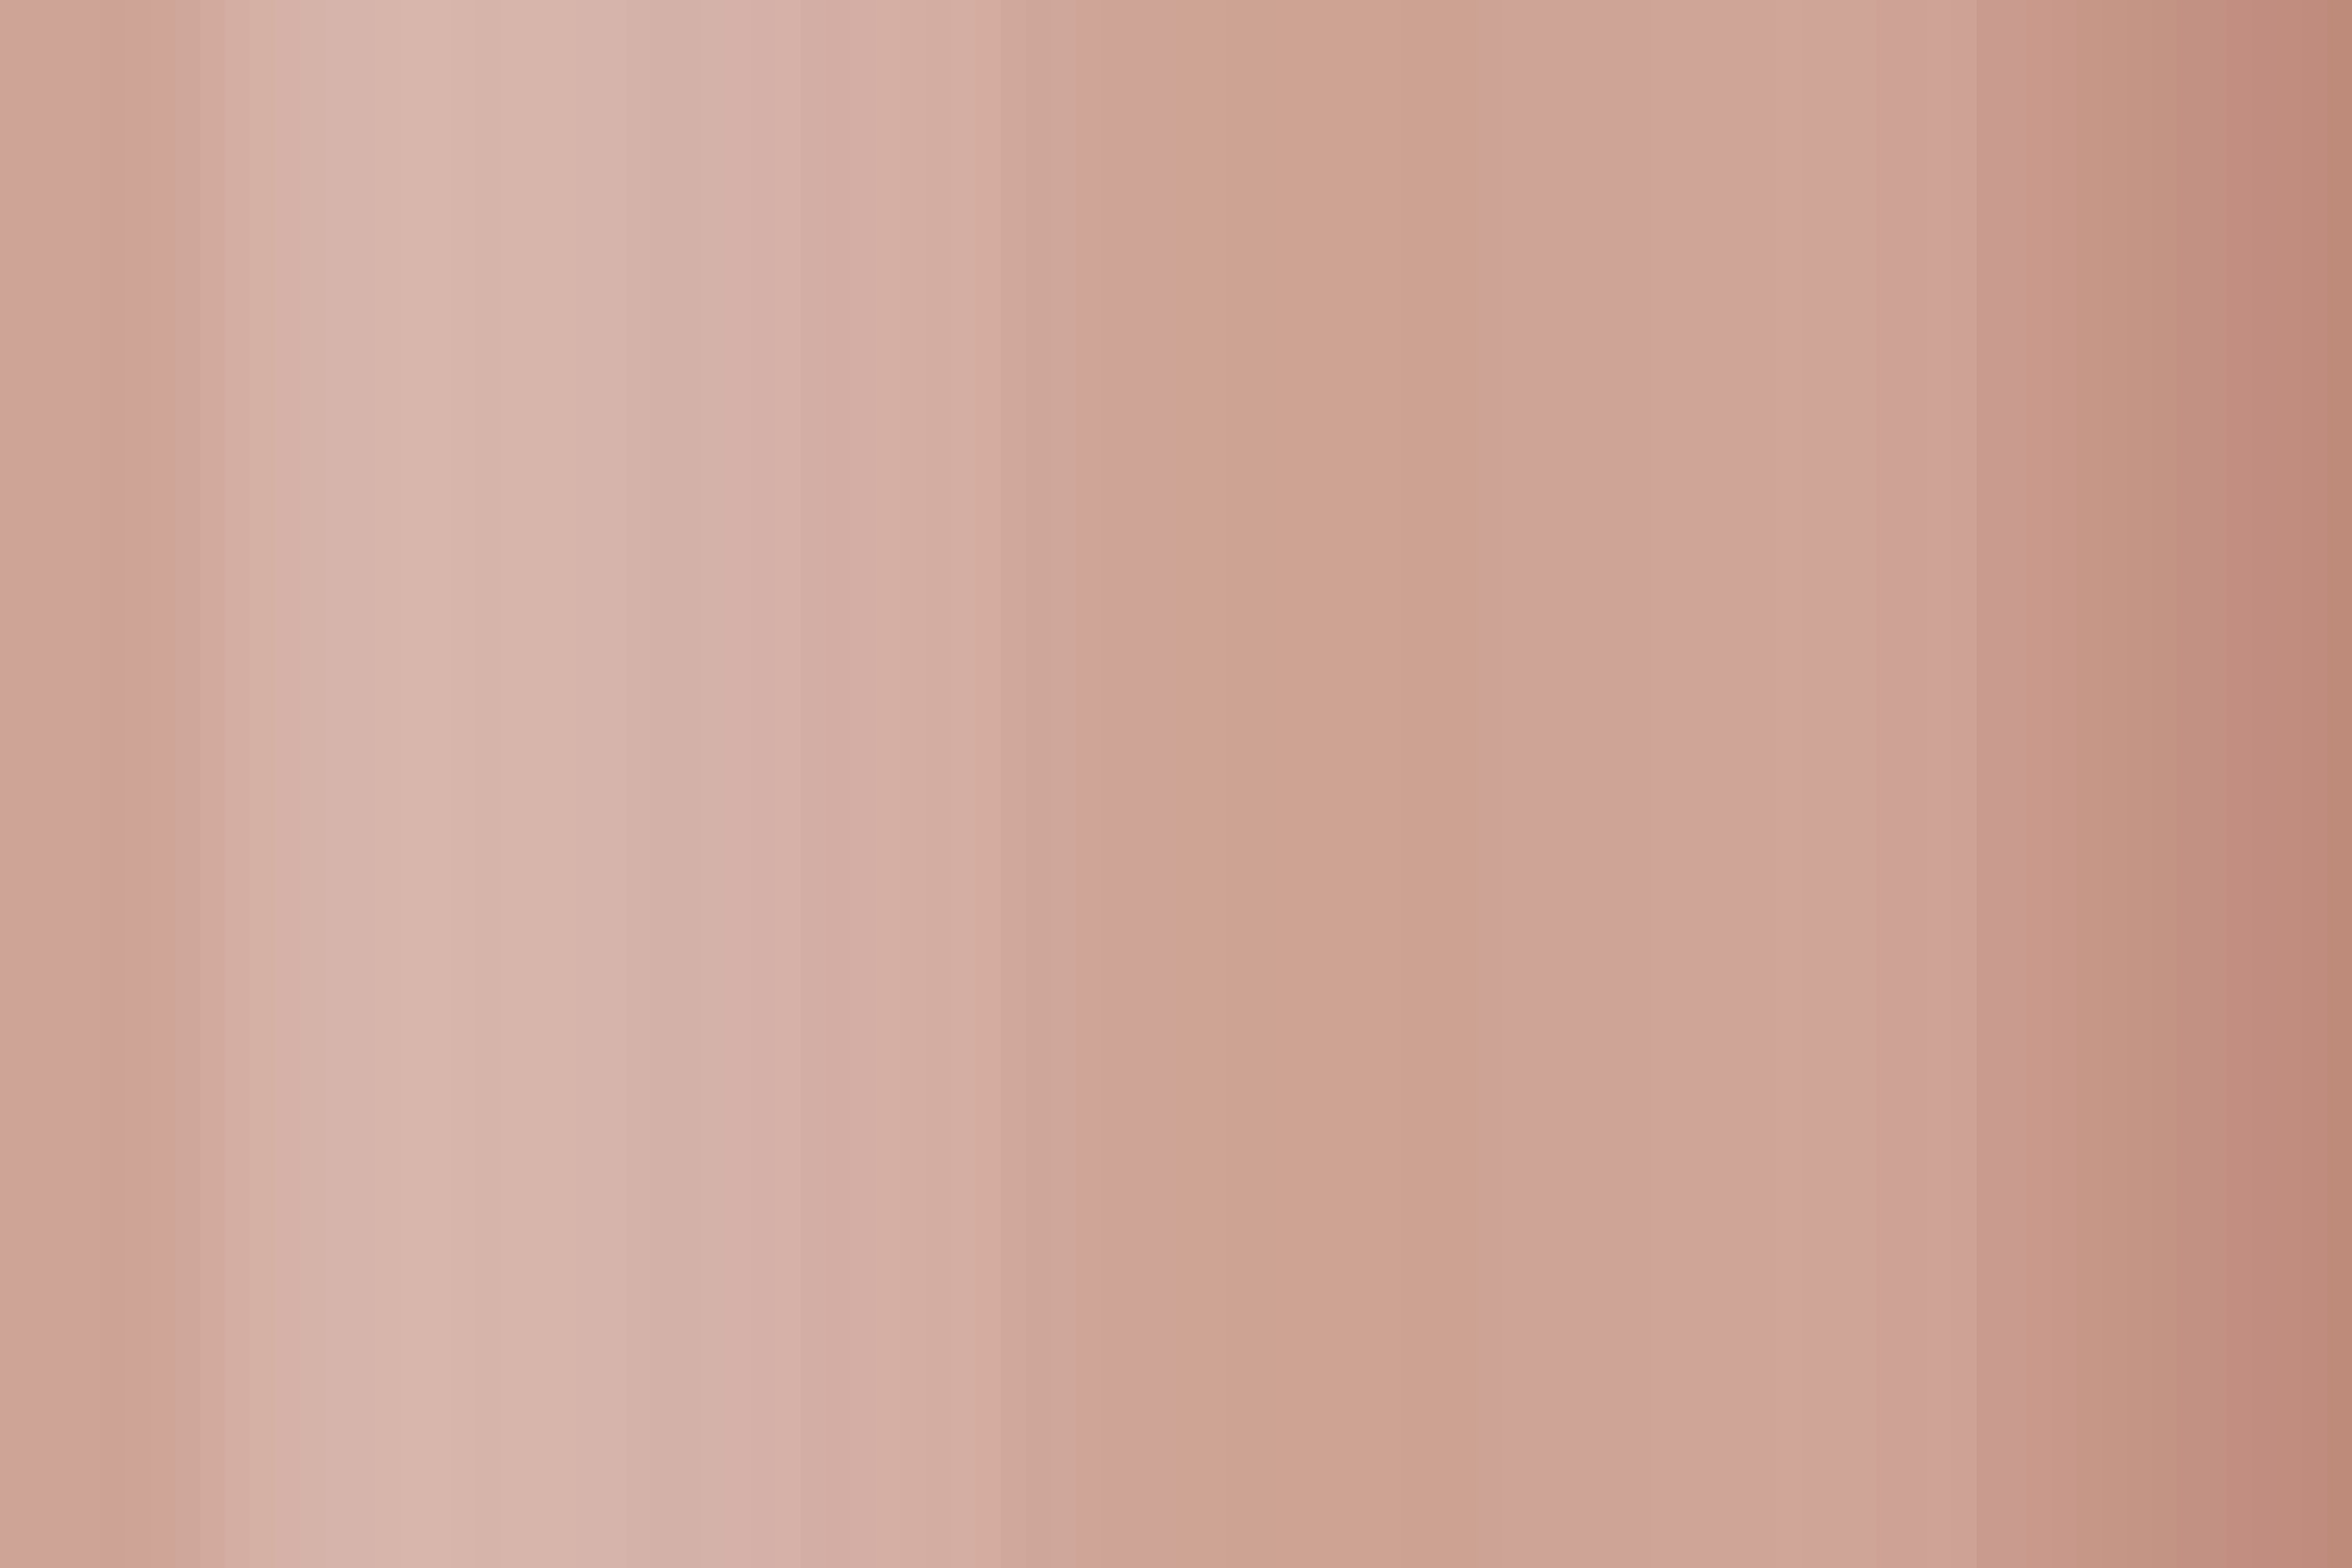

1
1
-------------------
../data/train_image/augmented/curtain/7Affi8_augmentedCrop1_augmented.jpg


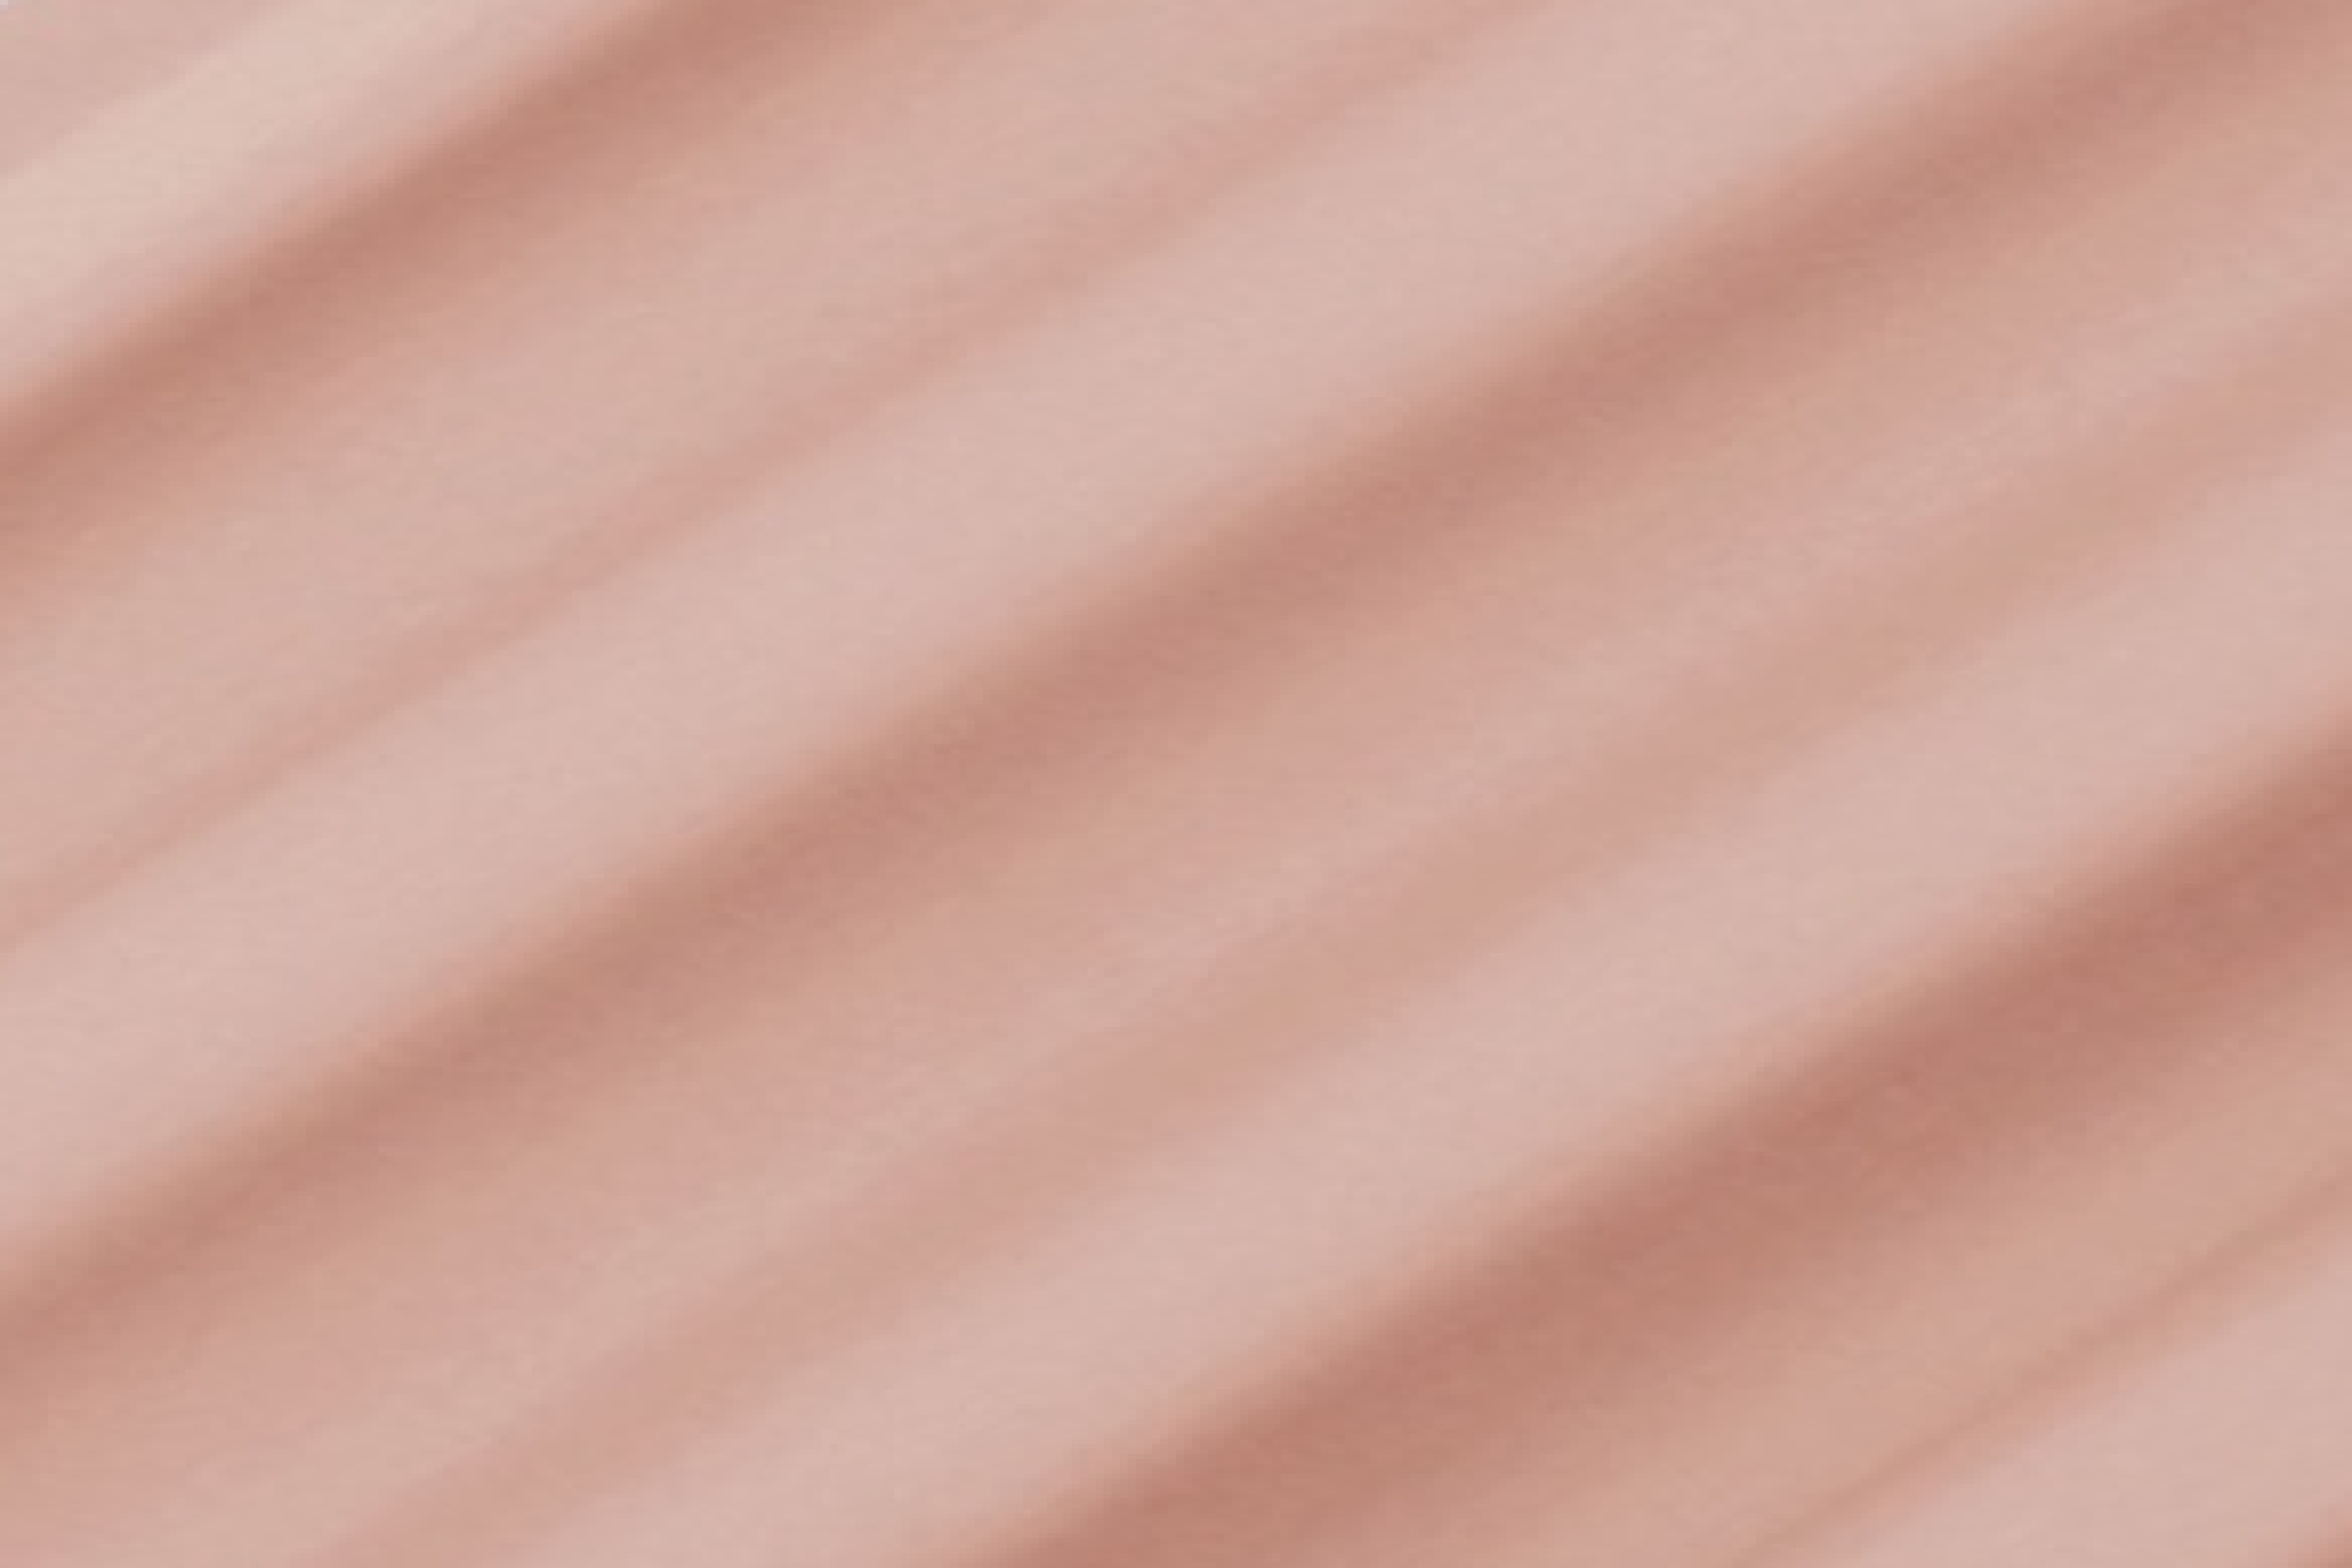

1
1
-------------------
../data/train_image/augmented/ambulance/5Crop2_augmentedCrop0_augmented.jpg


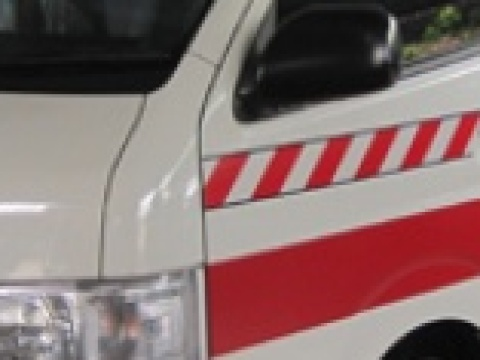

0
0
-------------------
../data/train_image/augmented/curtain/7Affi3_augmented.jpg


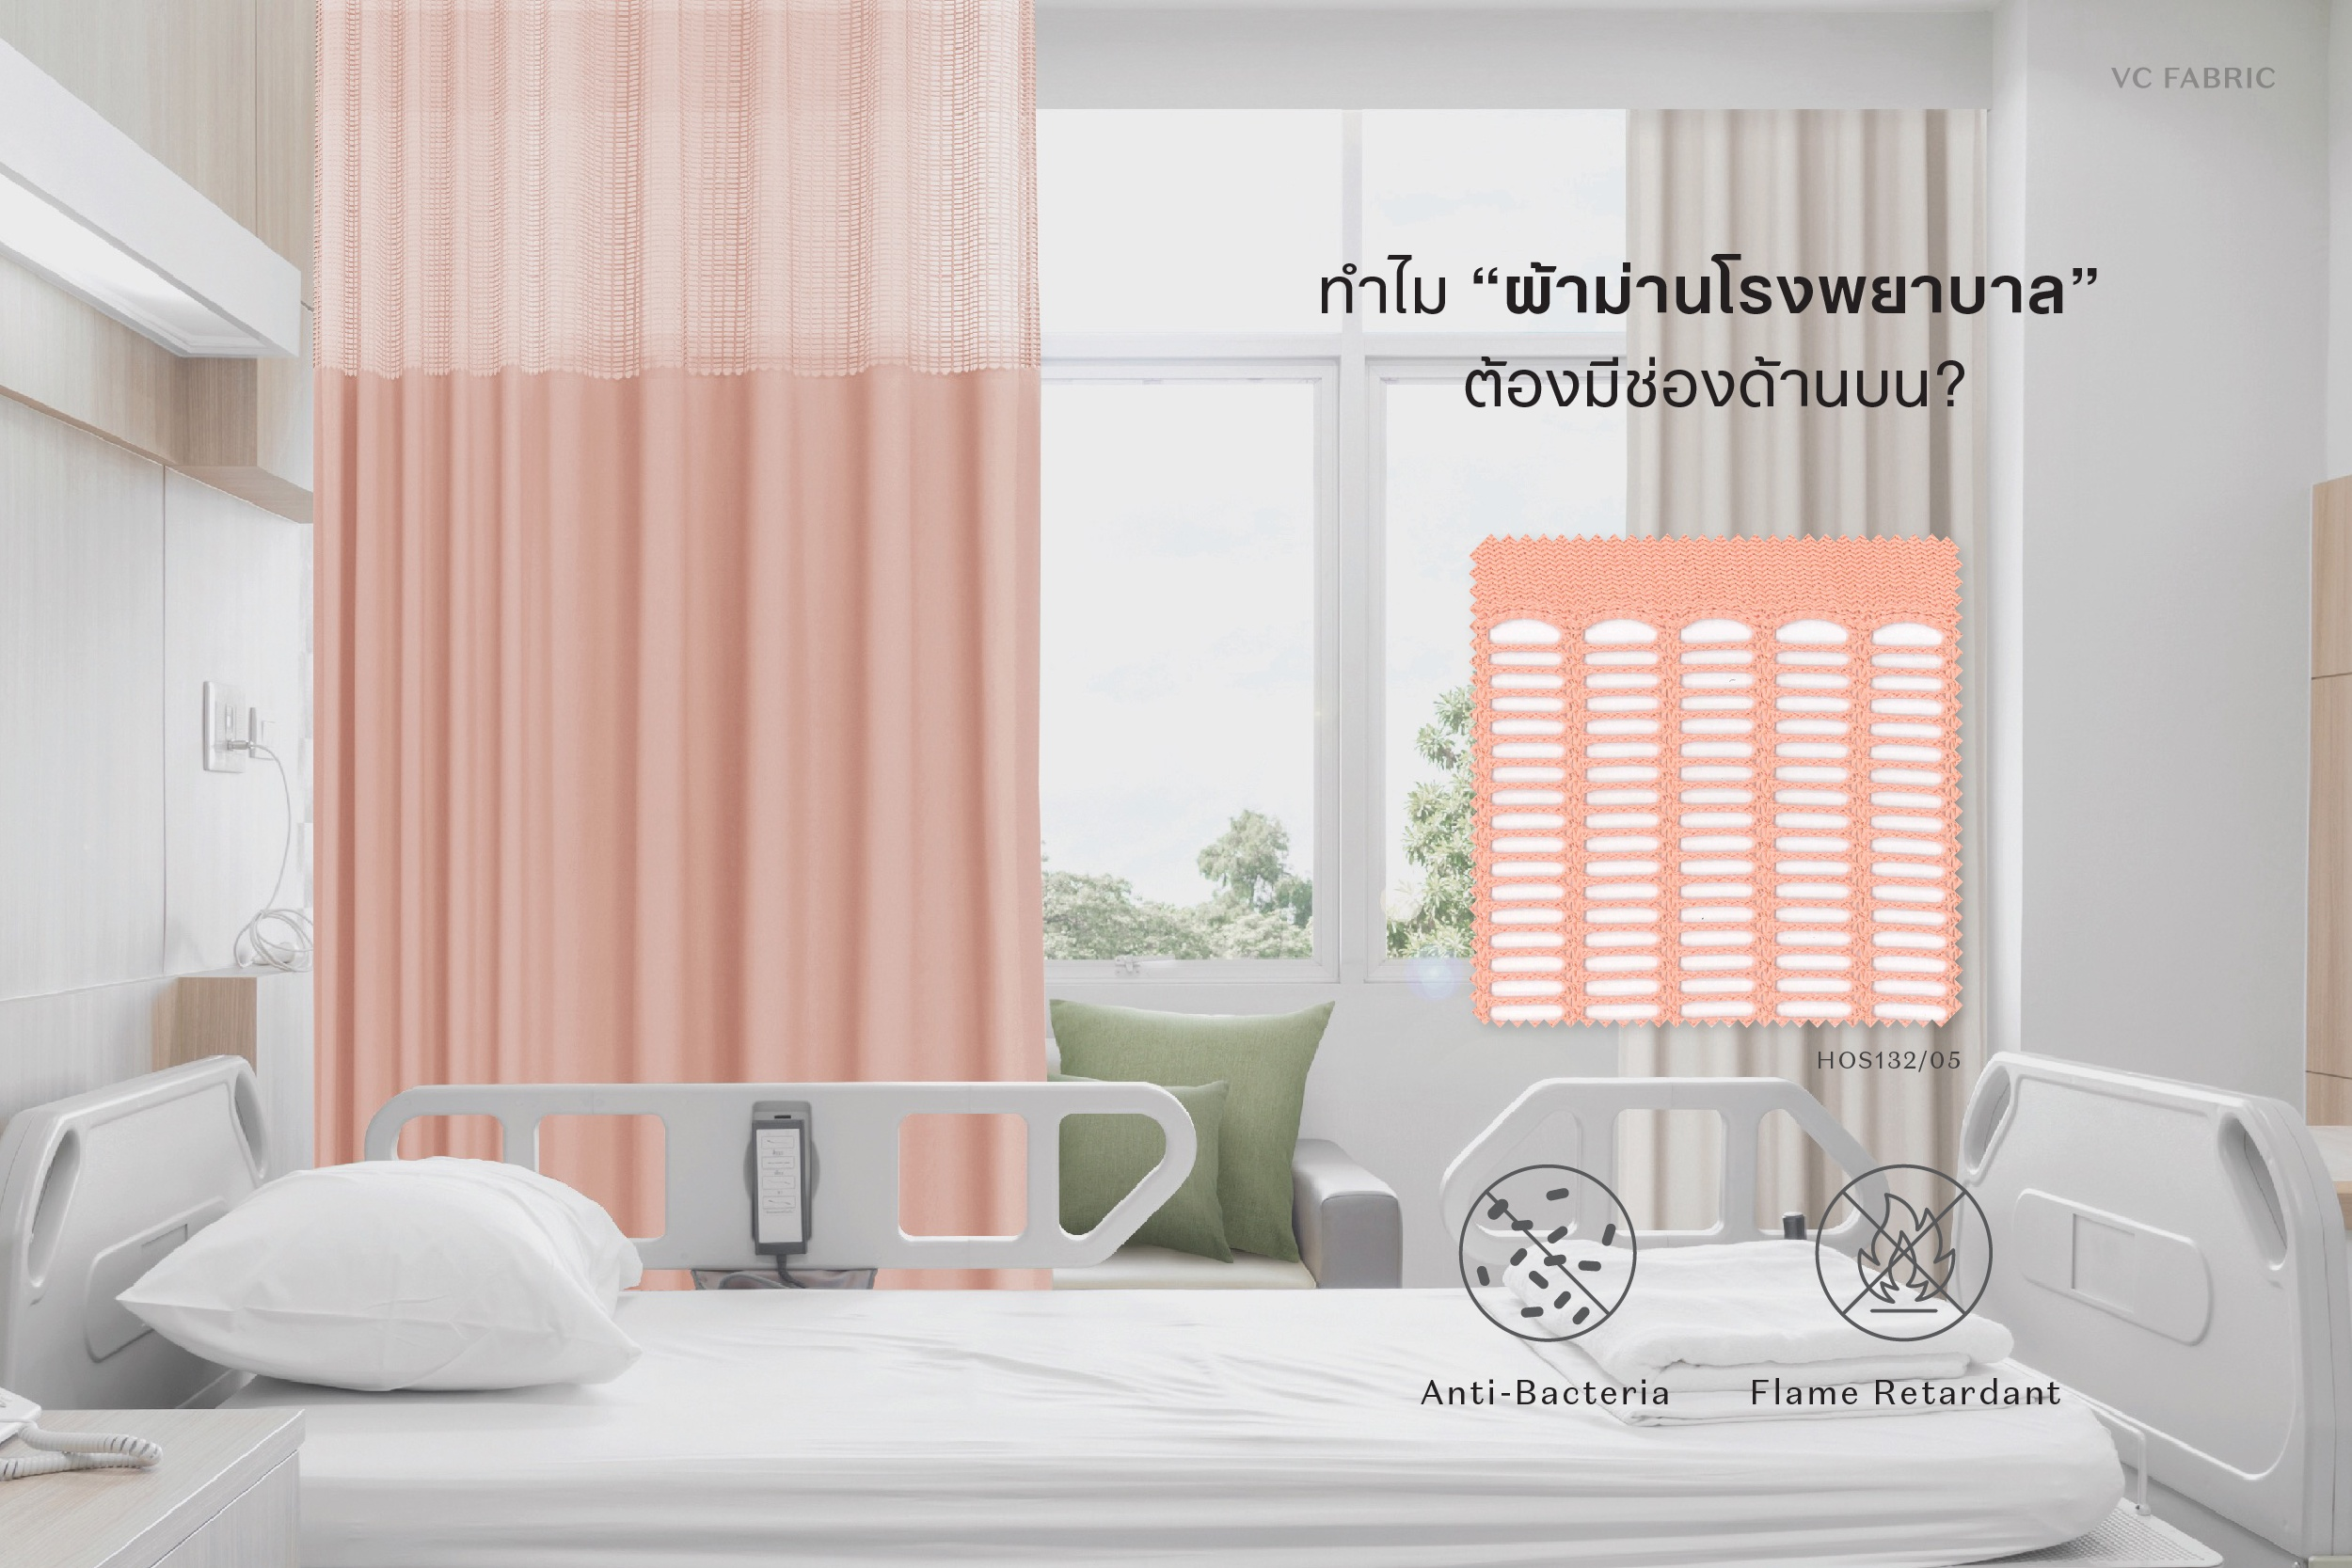

1
1
-------------------
../data/train_image/augmented/ambulance/7Crop2_augmentedCrop0_augmented.jpg


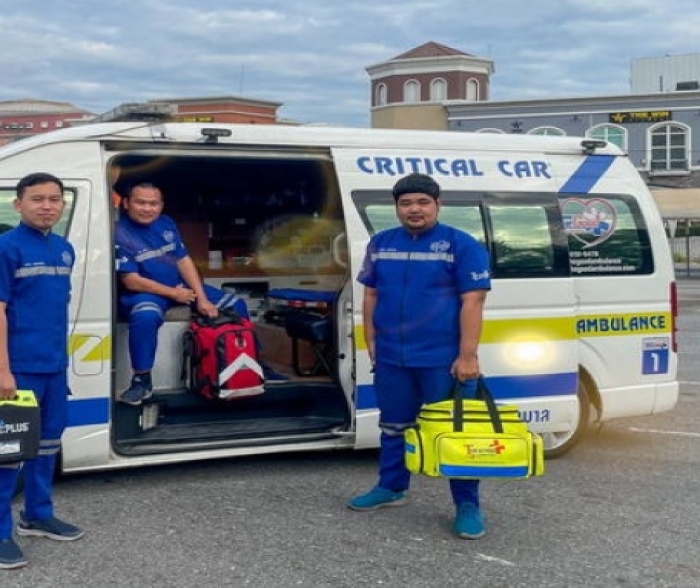

0
0
-------------------
../data/train_image/augmented/ambulance/7Flip1_augmentedCrop0_augmented.jpg


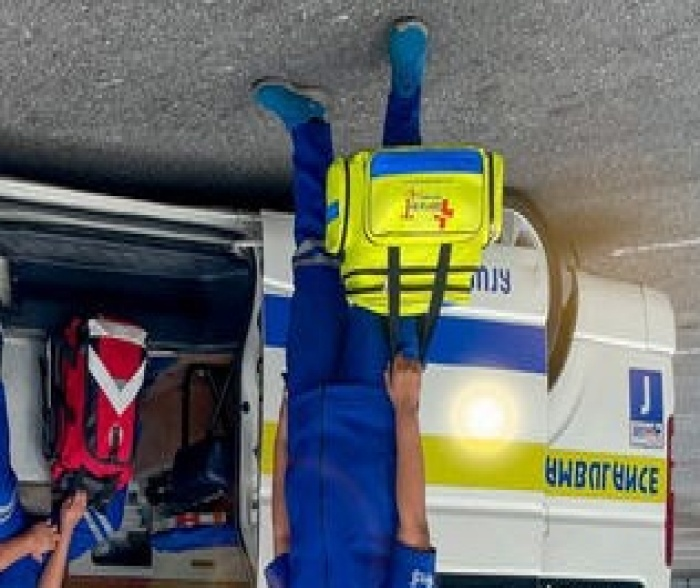

0
0
-------------------
../data/train_image/augmented/curtain/8Affi4_augmented.jpg


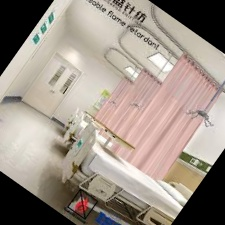

1
1
-------------------
../data/train_image/augmented/curtain/6Gaus10_augmentedCrop1_augmented.jpg


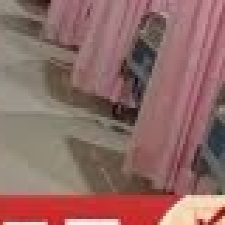

1
1
-------------------
../data/train_image/augmented/ambulance/6Affi8_augmentedCrop0_augmented.jpg


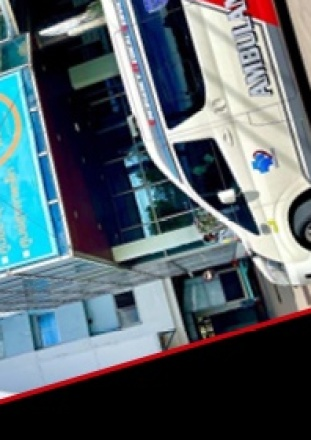

0
0
-------------------
../data/train_image/augmented/curtain/6Affi3_augmentedCrop0_augmented.jpg


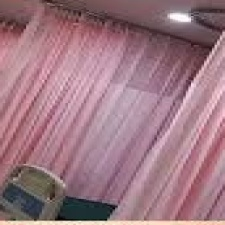

1
1
-------------------
../data/train_image/augmented/ambulance/7Flip1_augmentedCrop1_augmented.jpg


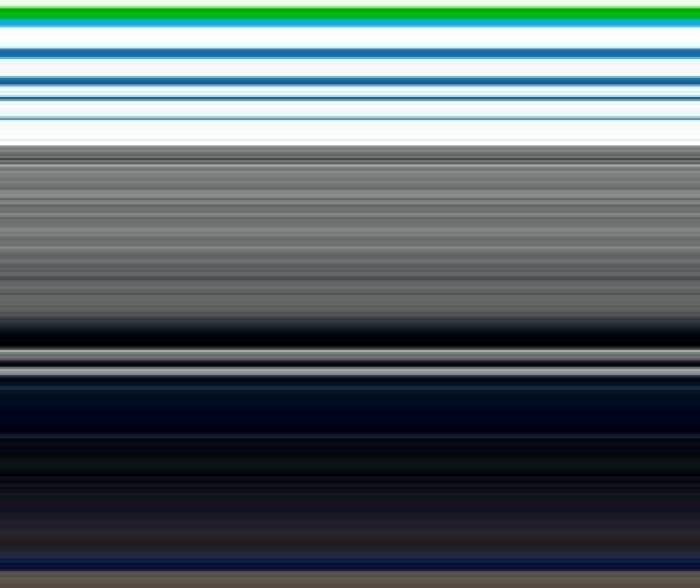

0
0
-------------------
../data/train_image/augmented/curtain/6Affi7_augmentedCrop0_augmented.jpg


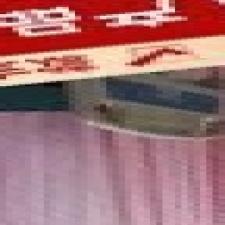

1
1
-------------------


In [626]:
# chech the train data that predicted correctly during fitting
y_pred = model.predict(valid_dataset, steps = val_steps)

# display the images that predicted correctly
for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == val_labels_list[i]:
        print(val_filenames_list[i])
        display(Image(val_filenames_list[i]))
        print(np.argmax(y_pred[i]))
        print(val_labels_list[i])
        print('-------------------')

../data/train_image/augmented/curtain/7Affi3_augmentedCrop0_augmented.jpg


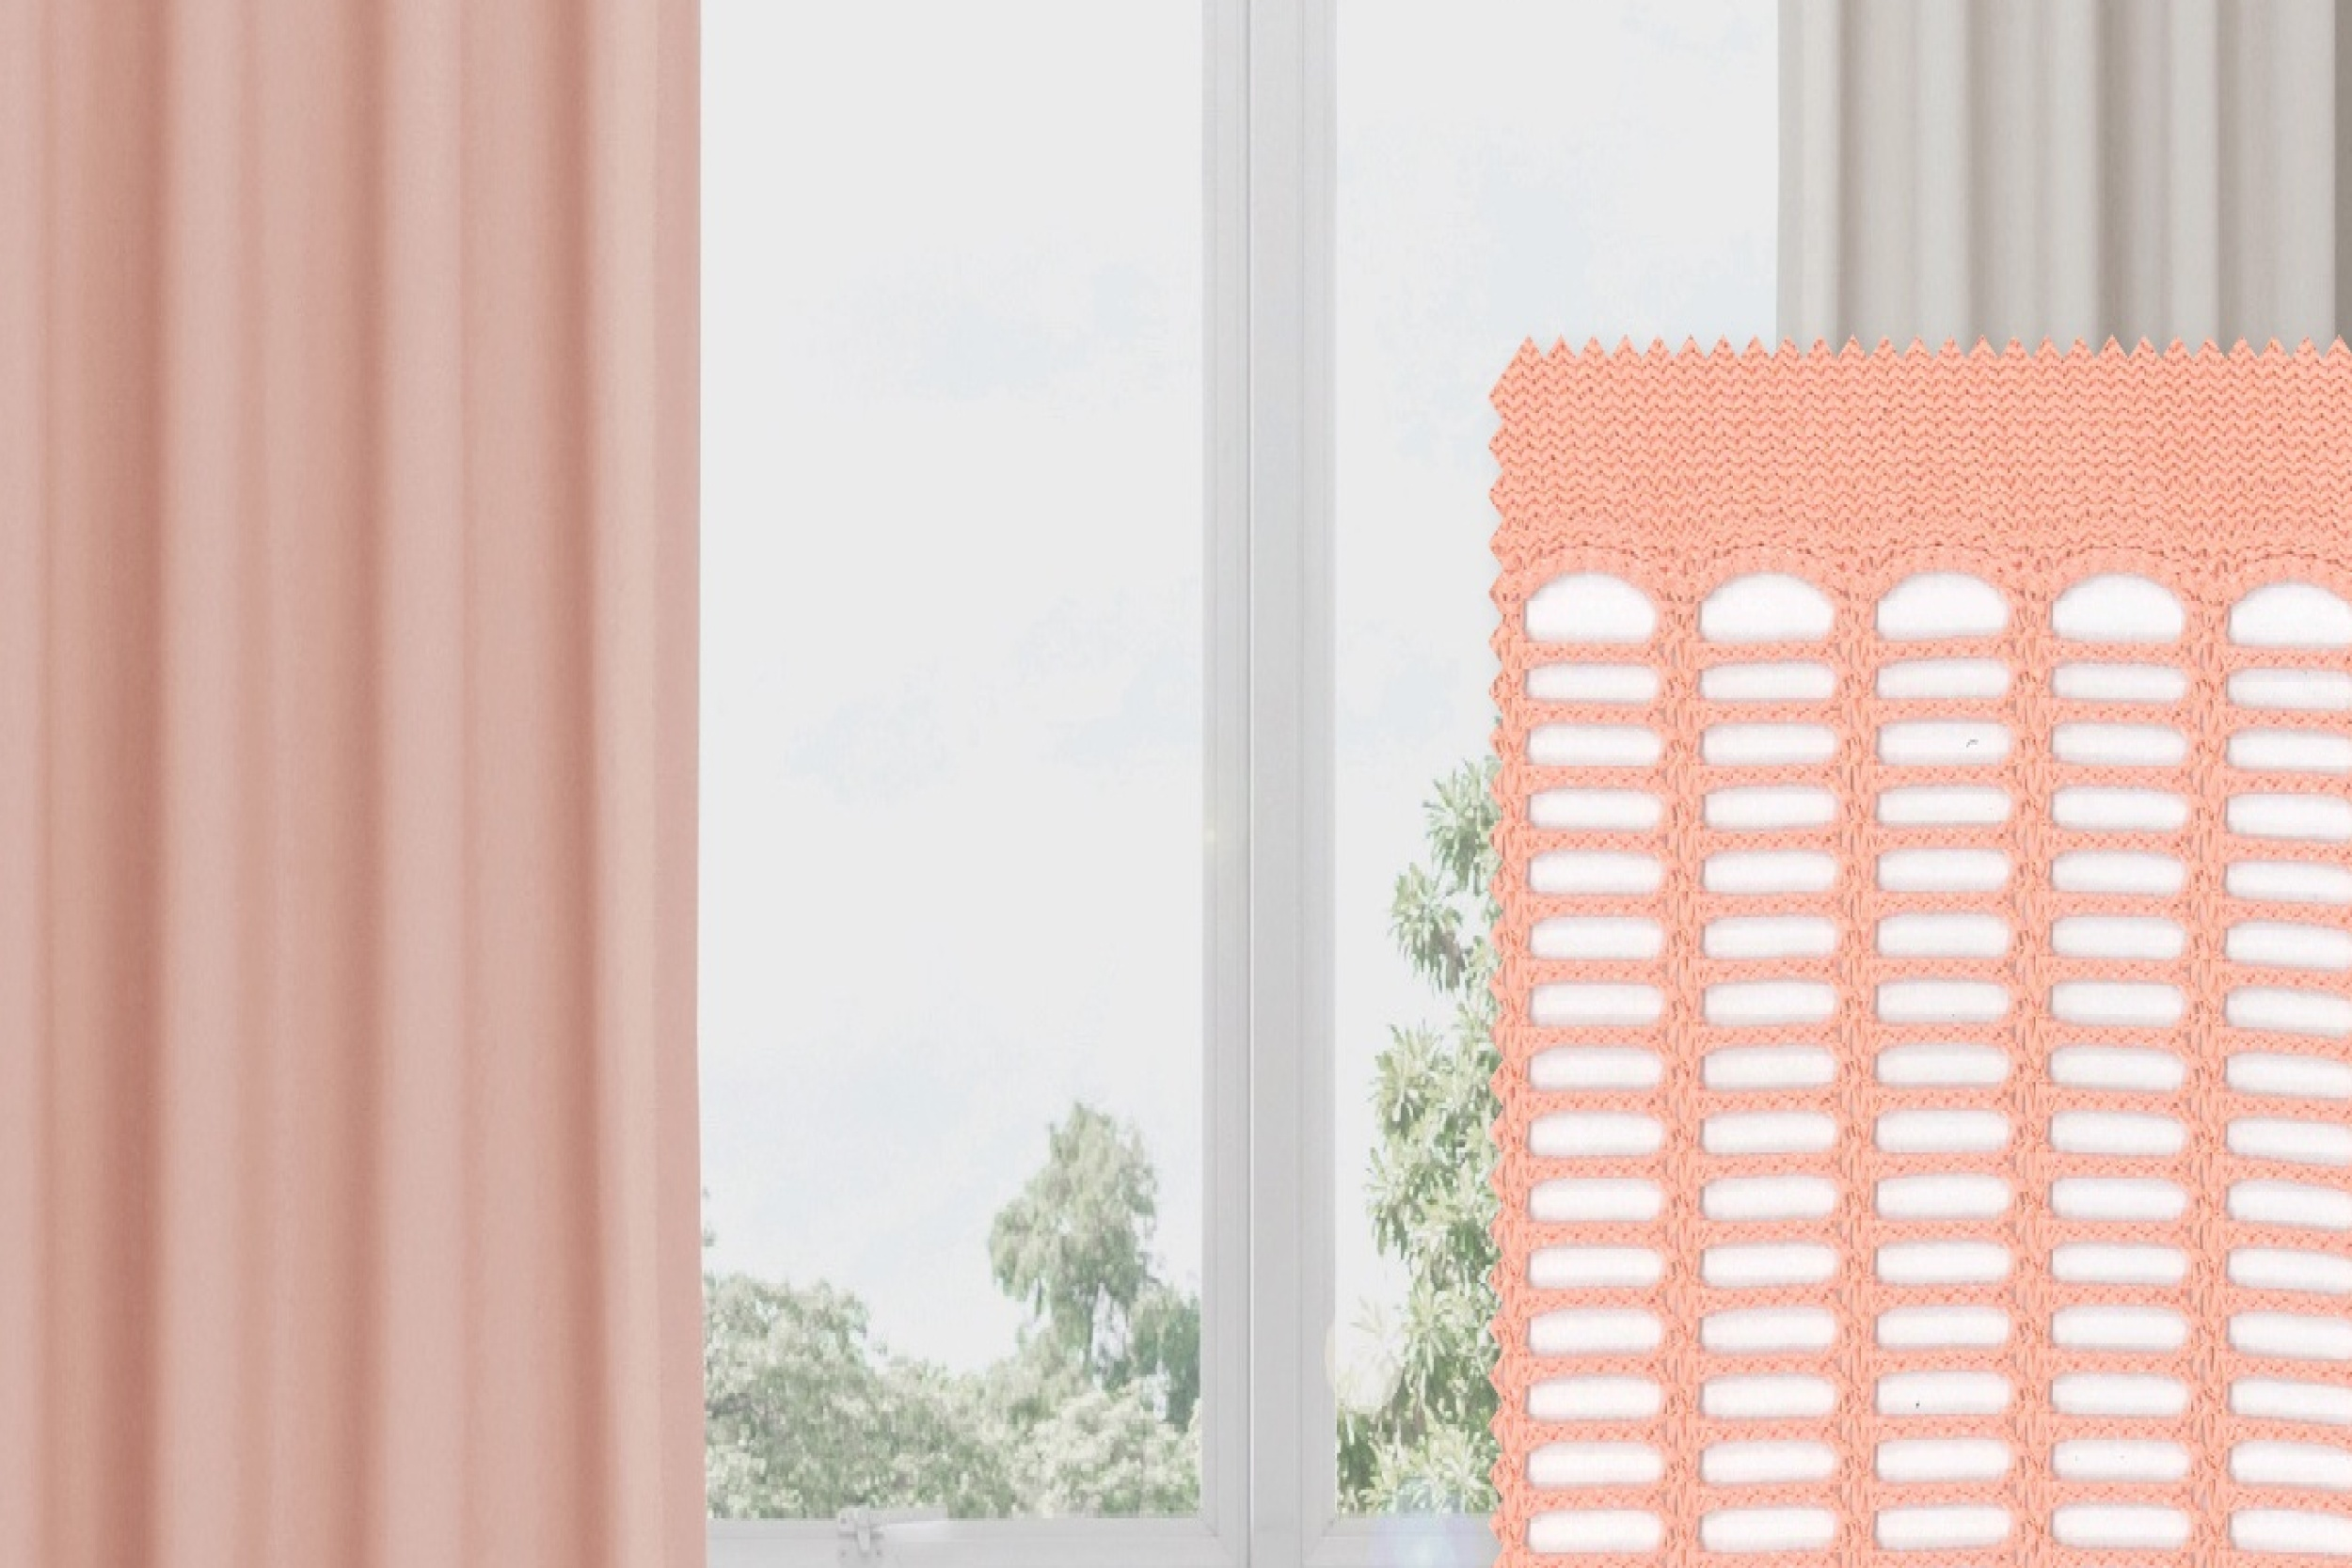

0
1
----
../data/train_image/augmented/curtain/7Affi5_augmented.jpg


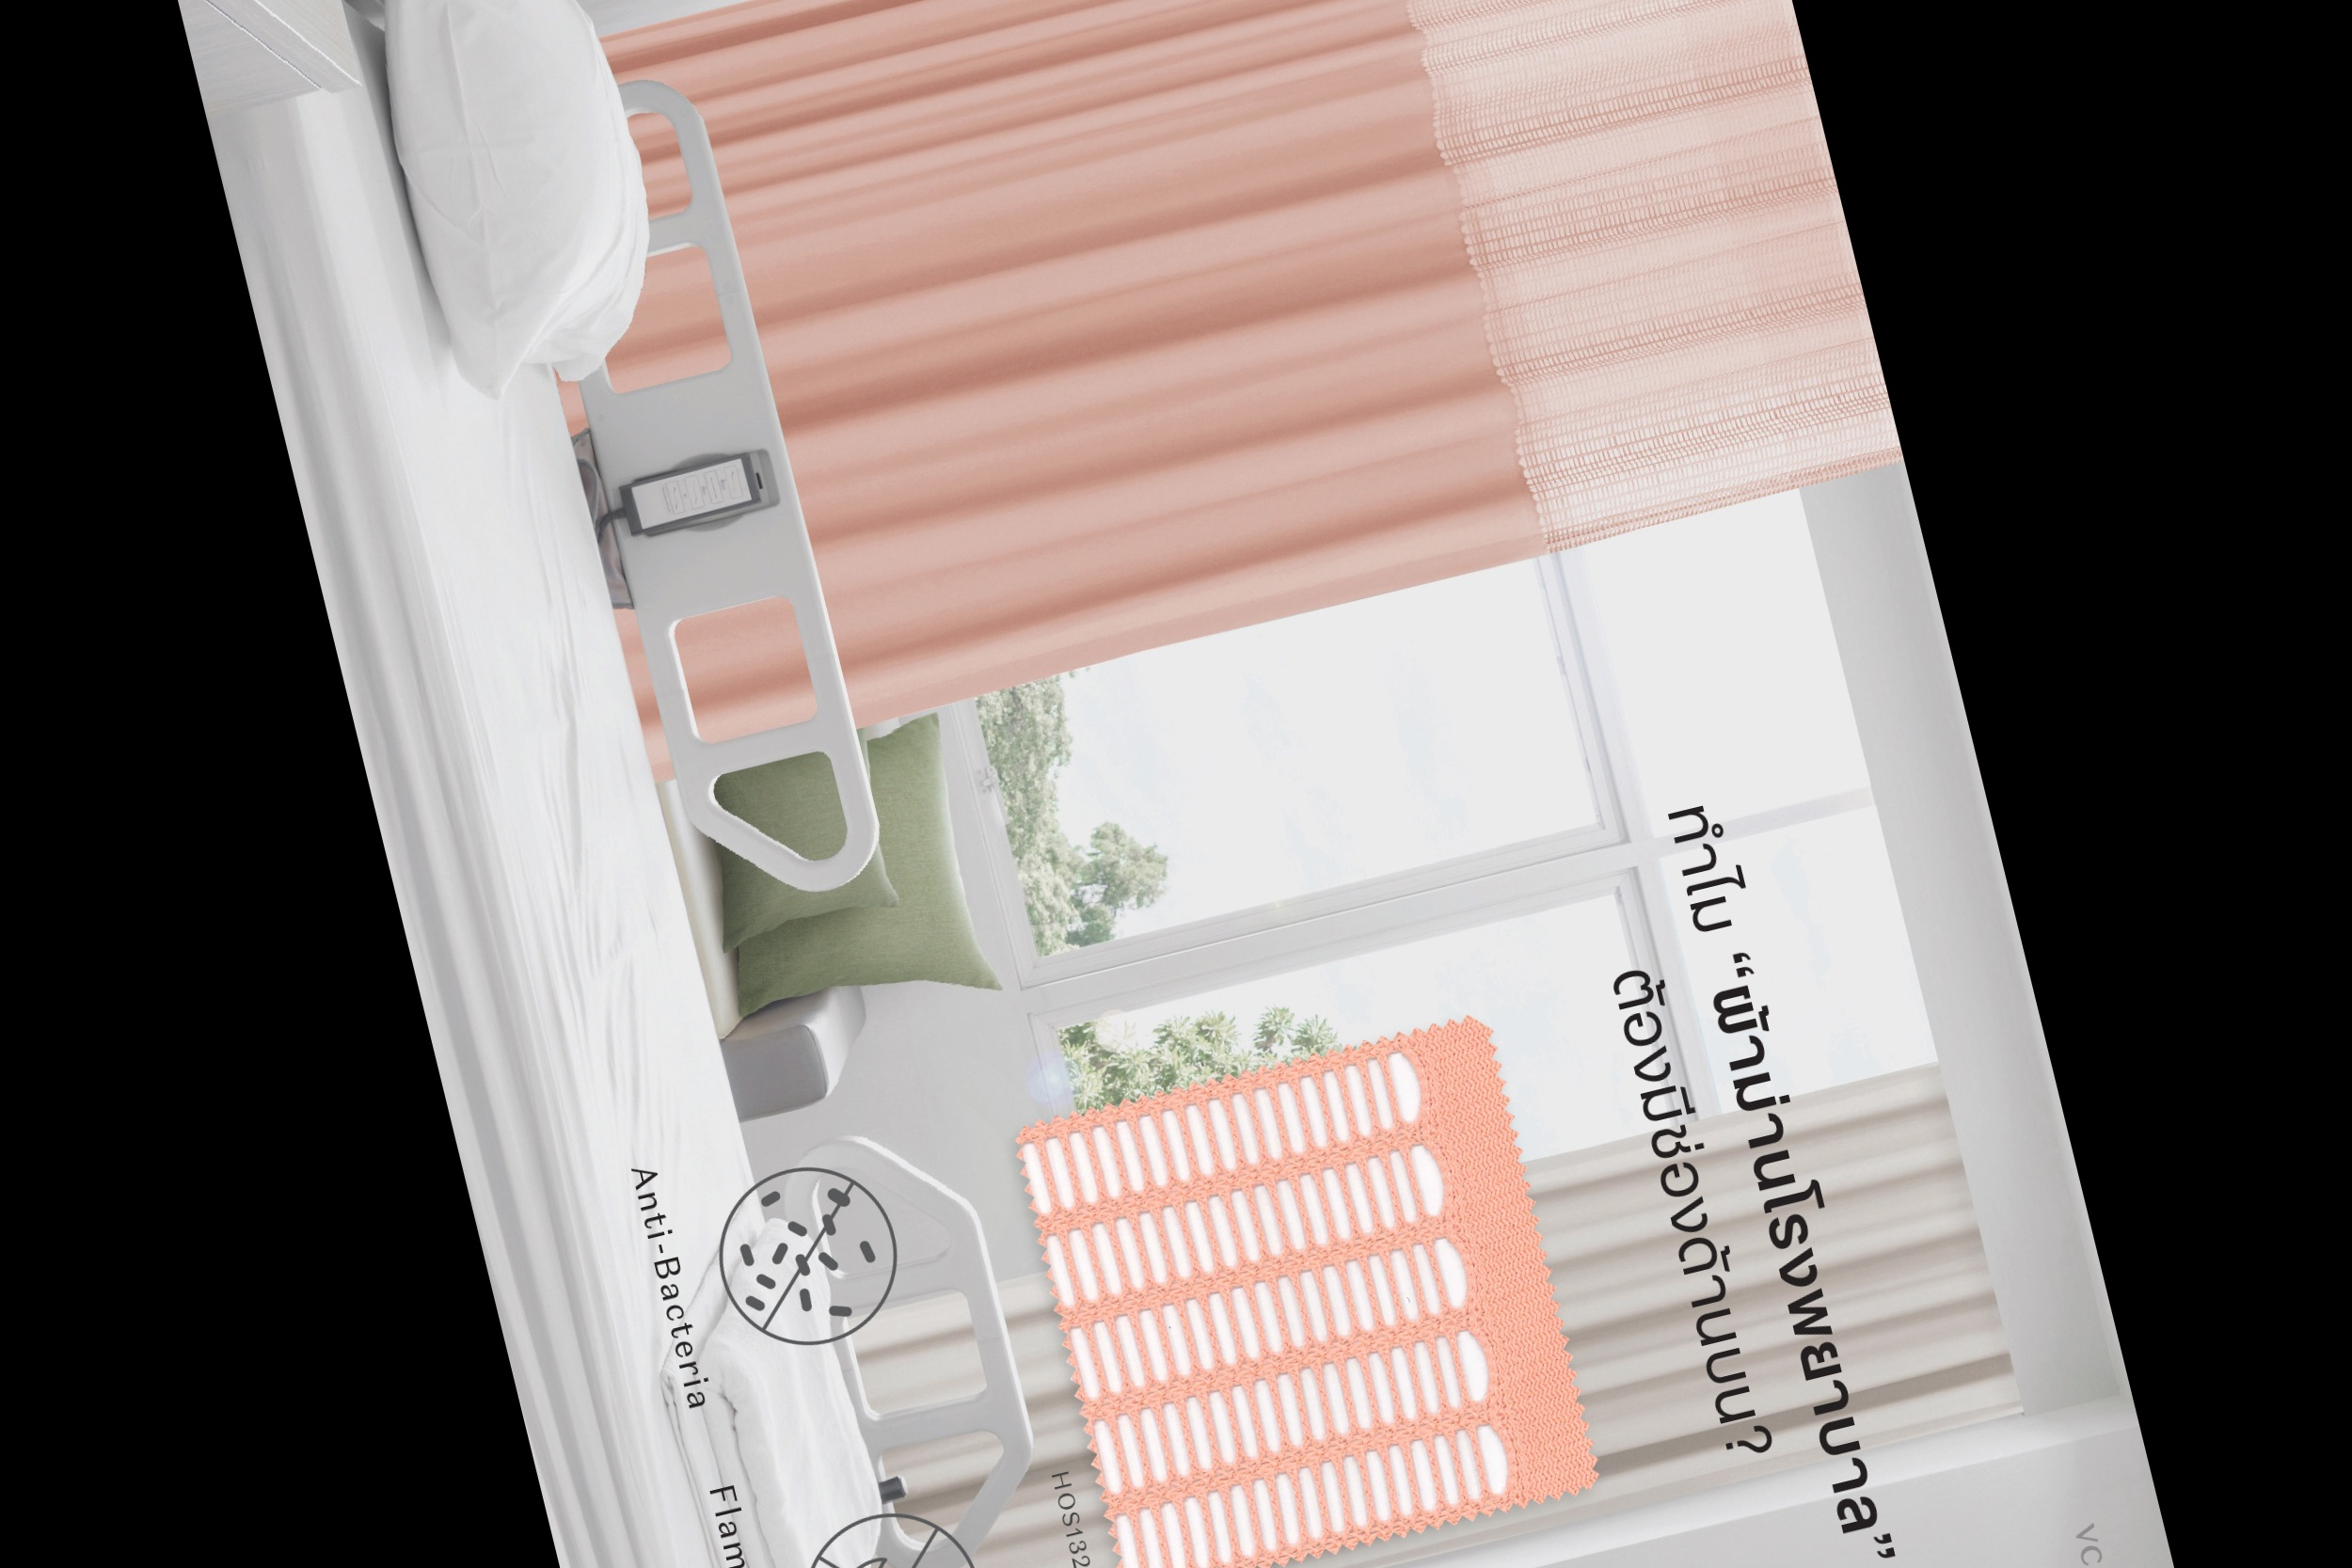

0
1
----
../data/train_image/augmented/ambulance/6Affi3_augmentedCrop1_augmented.jpg


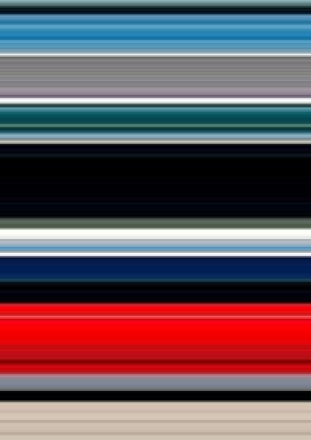

1
0
----
../data/train_image/augmented/curtain/7Affi9_augmentedCrop1_augmented.jpg


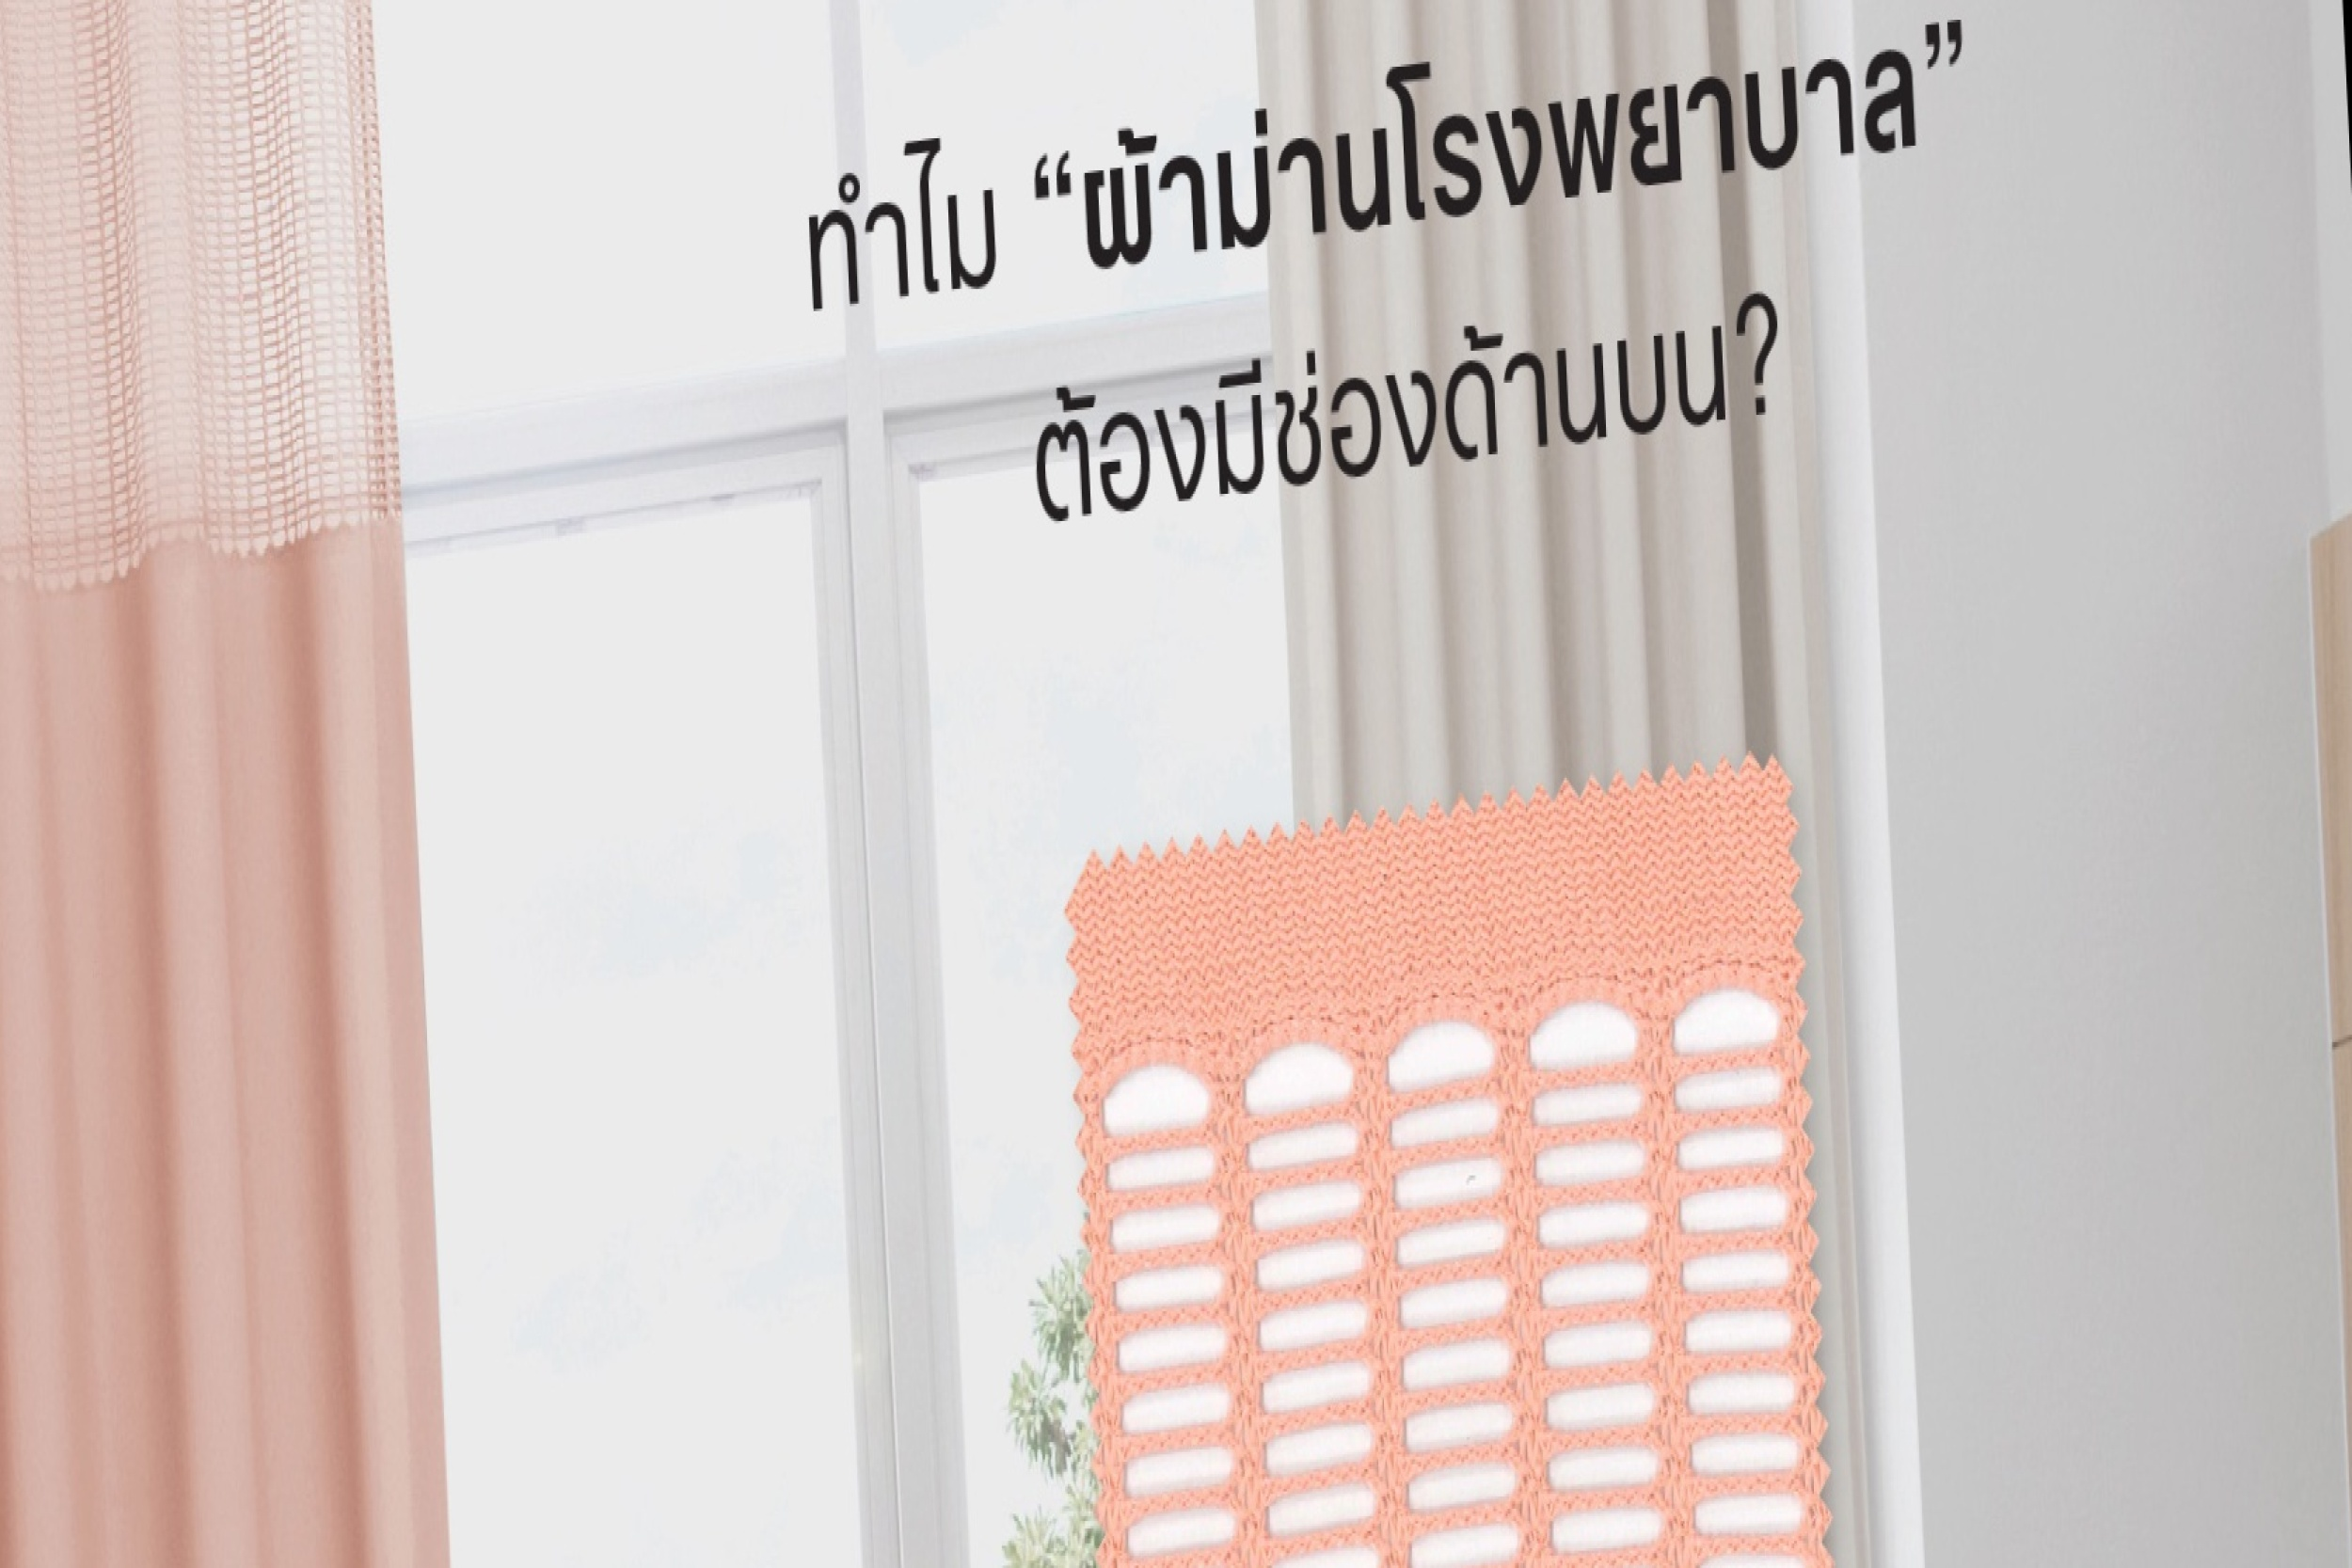

0
1
----
../data/train_image/augmented/ambulance/6Gaus10_augmentedCrop0_augmented.jpg


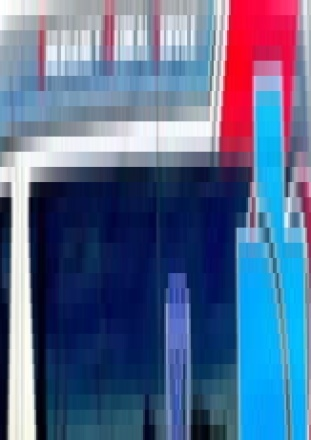

1
0
----
../data/train_image/augmented/curtain/9Affi8_augmentedCrop1_augmented.jpg


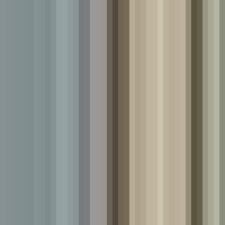

0
1
----
../data/train_image/augmented/ambulance/7Affi6_augmented.jpg


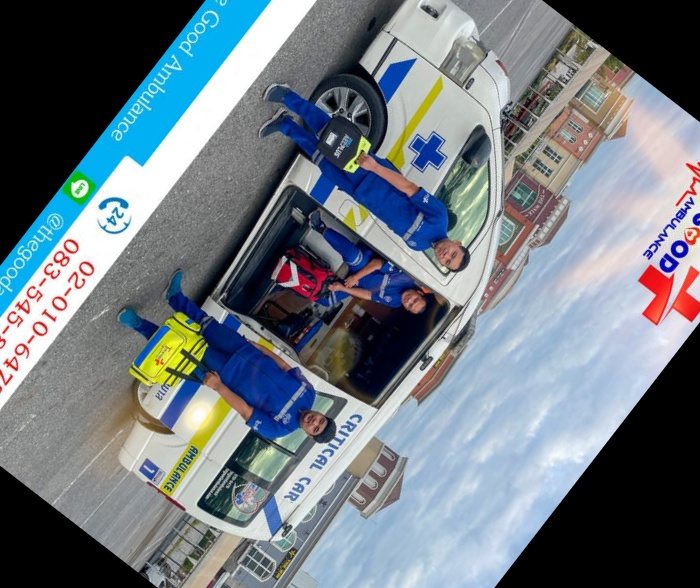

1
0
----
../data/train_image/augmented/curtain/9Crop2_augmentedCrop0_augmented.jpg


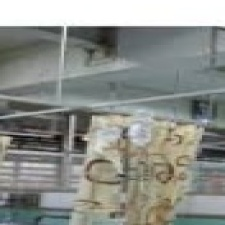

0
1
----
../data/train_image/augmented/curtain/8Affi5_augmentedCrop0_augmented.jpg


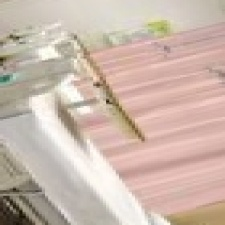

0
1
----
../data/train_image/augmented/curtain/8Gaus10_augmentedCrop0_augmented.jpg


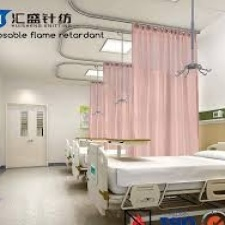

0
1
----
../data/train_image/augmented/ambulance/6Flip0_augmented.jpg


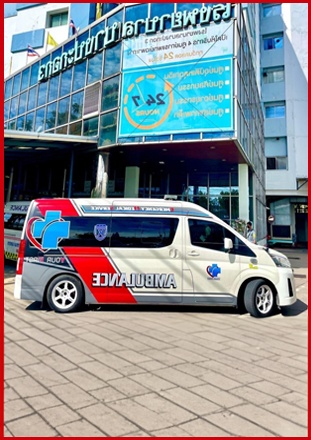

1
0
----
../data/train_image/augmented/curtain/8Affi6_augmented.jpg


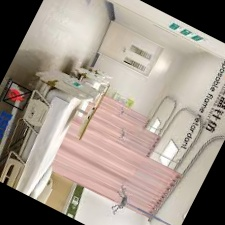

0
1
----


In [627]:
# display the images that predicted incorrectly
for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) != val_labels_list[i]:
        print(val_filenames_list[i])
        display(Image(val_filenames_list[i]))
        print(np.argmax(y_pred[i]))
        print(val_labels_list[i])
        print('----')

## Test 2nd time

Sample of test image 4:


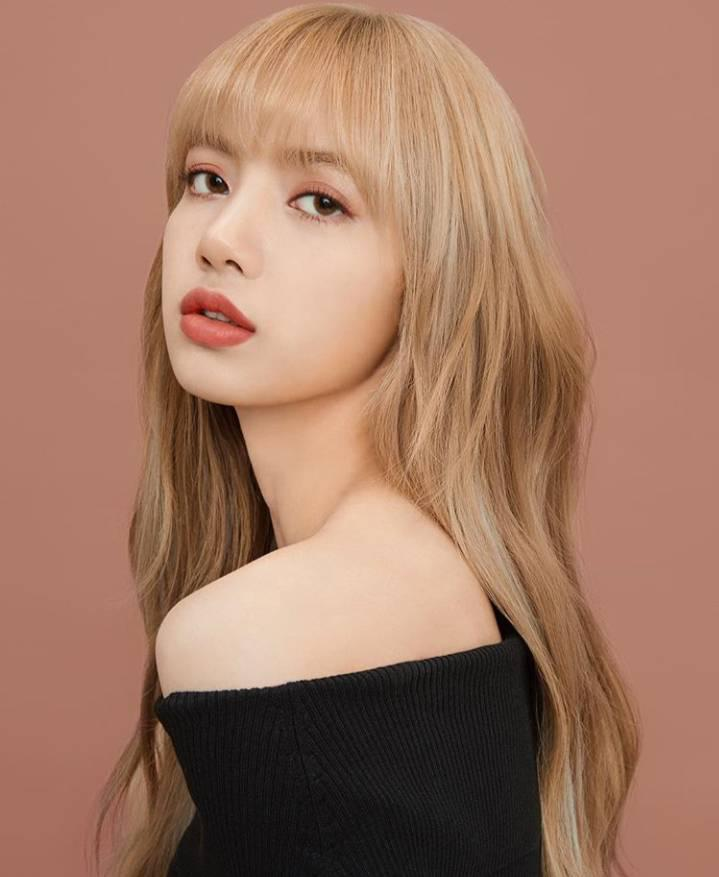

In [628]:
# Call test image for prediction
image_test_1 = '../data/test_image/1_amb.jpg'
image_test_2 = '../data/test_image/2_curtain.jpg'
image_test_3 = '../data/test_image/3_none.jpg'
image_test_4 = '../data/test_image/4_lisa.jpg'
filenames_test = [image_test_1, image_test_2, image_test_3, image_test_4]
print("Sample of test image 4:")
Image(image_test_4)

In [629]:
# Create list of file to run test
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [630]:
# Predict
preds = []
for x in x_test:
    preds.append(model_2.predict(x))

# Display result

for i in range(len(filenames_test)):
    print(filenames_test[i])
    if preds[i][0][0] > 0.9:
        print("It's an ambulance")
    else:
        print("None of them")

1/1 [==============================] - 0s 153ms/step
../data/test_image/1_amb.jpg
It's an ambulance
../data/test_image/2_curtain.jpg
None of them
../data/test_image/3_none.jpg
It's an ambulance
../data/test_image/4_lisa.jpg
It's an ambulance


### Model Fine-tuning

In [634]:
model_3=model
model_3.trainable = True

# Train 5 more layers from added layers
set_trainable = False
for layer in model_3.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:  
        layer.trainable = False

In [635]:
# Check the training layers
for layer in model_3.layers:
    print(layer.name)
    print(layer.trainable)

input_34
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
True
block5_conv2
True
block5_conv3
True
block5_pool
True
global_average_pooling2d_35
True
dense_70
True
dense_71
True


In [636]:
history = model_3.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 2,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/2


33/33 [==============================] - 39s 1s/step - loss: 1.0974 - accuracy: 0.7386 - val_loss: 1.5281 - val_accuracy: 0.7500
Epoch 2/2
33/33 [==============================] - 51s 2s/step - loss: 1.0537 - accuracy: 0.7424 - val_loss: 1.5281 - val_accuracy: 0.7500


In [637]:
metrics = model_3.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])


3/3 [==============================] - 2s 745ms/step - loss: 1.5281 - accuracy: 0.7500
model accuracy: 0.75


## Test 3rd time

Sample of test image 3:


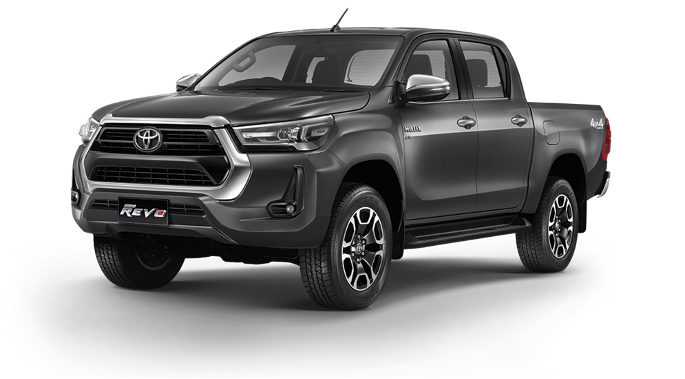

In [638]:
# Call test image for prediction
image_test_1 = '../data/test_image/1_amb.jpg'
image_test_2 = '../data/test_image/2_curtain.jpg'
image_test_3 = '../data/test_image/3_none.jpg'
image_test_4 = '../data/test_image/4_lisa.jpg'
filenames_test = [image_test_1, image_test_2, image_test_3, image_test_4]
print("Sample of test image 3:")
Image(image_test_3)

In [639]:
# Create list of file to run test
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [640]:
# Predict
preds = []
for x in x_test:
    preds.append(model_3.predict(x))

# Display result

for i in range(len(filenames_test)):
    print(filenames_test[i])
    if preds[i][0][0] > 0.9:
        print("It's an ambulance")
    else:
        print("None of them")

1/1 [==============================] - 0s 178ms/step
../data/test_image/1_amb.jpg
It's an ambulance
../data/test_image/2_curtain.jpg
None of them
../data/test_image/3_none.jpg
It's an ambulance
../data/test_image/4_lisa.jpg
It's an ambulance


---

## Demostration

For every second of the video, the model will identify whether it is "Ambulance" scene or "Emergency Room" scene or none of them

Using picture_prep.ipynb to run pre-processing code to convert target video into multiple pictures (number of pictures = duration in seconds of the video)

In [729]:
# Actual labels
df_result = pd.read_csv('../data/test_data/video_result.csv')
df_result.set_index('Duration', inplace=True)


In [730]:
# Call test image for prediction
folder_path_test = '../data/test_data/test_set1/'
files_test = [f for f in os.listdir(folder_path_test) if os.path.isfile(os.path.join(folder_path_test, f))]
filenames_test = []
for file in files_test:
    filenames_test.append(folder_path_test+file)



In [731]:
# Create list of filenames for prediction
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [732]:
# Create list of predictions
preds = []
for x in x_test:
    preds.append(model_3.predict(x))

1/1 [==============================] - 0s 169ms/step


In [733]:
# Convert integer to hour:minute:second
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [734]:
# to overcome sorting issue
def extract_number(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# create dataframe to store filenames and predictions
df = pd.DataFrame(filenames_test, columns = ["filename"])
df = df.iloc[df['filename'].map(extract_number).argsort()]
df['Seconds'] = pd.Series([x for x in range(len(filenames_test))], index=df.index) # Add seconds column
df['Minute-th'] = pd.Series([convert(x) for x in df['Seconds']], index=df.index) # add time column 
df['Ambulance'] = pd.Series([preds[x][0][0] for x in range(len(preds))], index=df.index) # Add prediction prob for ambulance
df['pred_ambulance'] = np.where(df['Ambulance'] > 0.80, 1, 0)
df = df.join(df_result, on='Seconds')
df = df.drop(columns=['video_2', 'video_3', 'video_4'])
df


df


filename  Seconds Minute-th  Ambulance  \
0    ../data/test_data/test_set1/1.jpg        0   0:00:00   0.031042   
11   ../data/test_data/test_set1/2.jpg        1   0:00:01   0.038992   
22   ../data/test_data/test_set1/3.jpg        2   0:00:02   0.090228   
33   ../data/test_data/test_set1/4.jpg        3   0:00:03   0.071325   
42   ../data/test_data/test_set1/5.jpg        4   0:00:04   0.243953   
43   ../data/test_data/test_set1/6.jpg        5   0:00:05   0.488953   
44   ../data/test_data/test_set1/7.jpg        6   0:00:06   0.024882   
45   ../data/test_data/test_set1/8.jpg        7   0:00:07   0.037350   
46   ../data/test_data/test_set1/9.jpg        8   0:00:08   0.096951   
1   ../data/test_data/test_set1/10.jpg        9   0:00:09   0.082492   
2   ../data/test_data/test_set1/11.jpg       10   0:00:10   0.067877   
3   ../data/test_data/test_set1/12.jpg       11   0:00:11   0.031042   
4   ../data/test_data/test_set1/13.jpg       12   0:00:12   0.189315   
5   ../data/test_data/test_set1/14.jpg       13   0:00:13   0.000075   
6   ../data/test_data/test_set1/15.jpg       14   0:00:14   0.000571   
7   ../data/test_data/test_set1/16.jpg       15   0:00:15   0.052170   
8   ../data/test_data/test_set1/17.jpg       16   0:00:16   0.001397   
9   ../data/test_data/test_set1/18.jpg       17   0:00:17   0.000864   
10  ../data/test_data/test_set1/19.jpg       18   0:00:18   0.999819   
12  ../data/test_data/test_set1/20.jpg       19   0:00:19   0.861426   
13  ../data/test_data/test_set1/21.jpg       20   0:00:20   0.486708   
14  ../data/test_data/test_set1/22.jpg       21   0:00:21   0.982787   
15  ../data/test_data/test_set1/23.jpg       22   0:00:22   0.031042   
16  ../data/test_data/test_set1/24.jpg       23   0:00:23   0.678861   
17  ../data/test_data/test_set1/25.jpg       24   0:00:24   0.917123   
18  ../data/test_data/test_set1/26.jpg       25   0:00:25   0.521195   
19  ../data/test_data/test_set1/27.jpg       26   0:00:26   0.097491   
20  ../data/test_data/test_set1/28.jpg       27   0:00:27   0.060822   
21  ../data/test_data/test_set1/29.jpg       28   0:00:28   0.013890   
23  ../data/test_data/test_set1/30.jpg       29   0:00:29   0.567296   
24  ../data/test_data/test_set1/31.jpg       30   0:00:30   0.009962   
25  ../data/test_data/test_set1/32.jpg       31   0:00:31   0.099643   
26  ../data/test_data/test_set1/33.jpg       32   0:00:32   0.018512   
27  ../data/test_data/test_set1/34.jpg       33   0:00:33   0.031042   
28  ../data/test_data/test_set1/35.jpg       34   0:00:34   0.059338   
29  ../data/test_data/test_set1/36.jpg       35   0:00:35   0.386655   
30  ../data/test_data/test_set1/37.jpg       36   0:00:36   0.002299   
31  ../data/test_data/test_set1/38.jpg       37   0:00:37   0.013182   
32  ../data/test_data/test_set1/39.jpg       38   0:00:38   0.069728   
34  ../data/test_data/test_set1/40.jpg       39   0:00:39   0.955156   
35  ../data/test_data/test_set1/41.jpg       40   0:00:40   0.005432   
36  ../data/test_data/test_set1/42.jpg       41   0:00:41   0.123042   
37  ../data/test_data/test_set1/43.jpg       42   0:00:42   0.031042   
38  ../data/test_data/test_set1/44.jpg       43   0:00:43   0.014079   
39  ../data/test_data/test_set1/45.jpg       44   0:00:44   0.157435   
40  ../data/test_data/test_set1/46.jpg       45   0:00:45   0.538209   
41  ../data/test_data/test_set1/47.jpg       46   0:00:46   0.002077   

    pred_ambulance  video_1  
0                0        0  
11               0        0  
22               0        0  
33               0        0  
42               0        0  
43               0        0  
44               0        0  
45               0        0  
46               0        1  
1                0        1  
2                0        1  
3                0        1  
4                0        1  
5                0        1  
6                0        1  
7                0        1  
8                0        1  
9                0        1  
10 

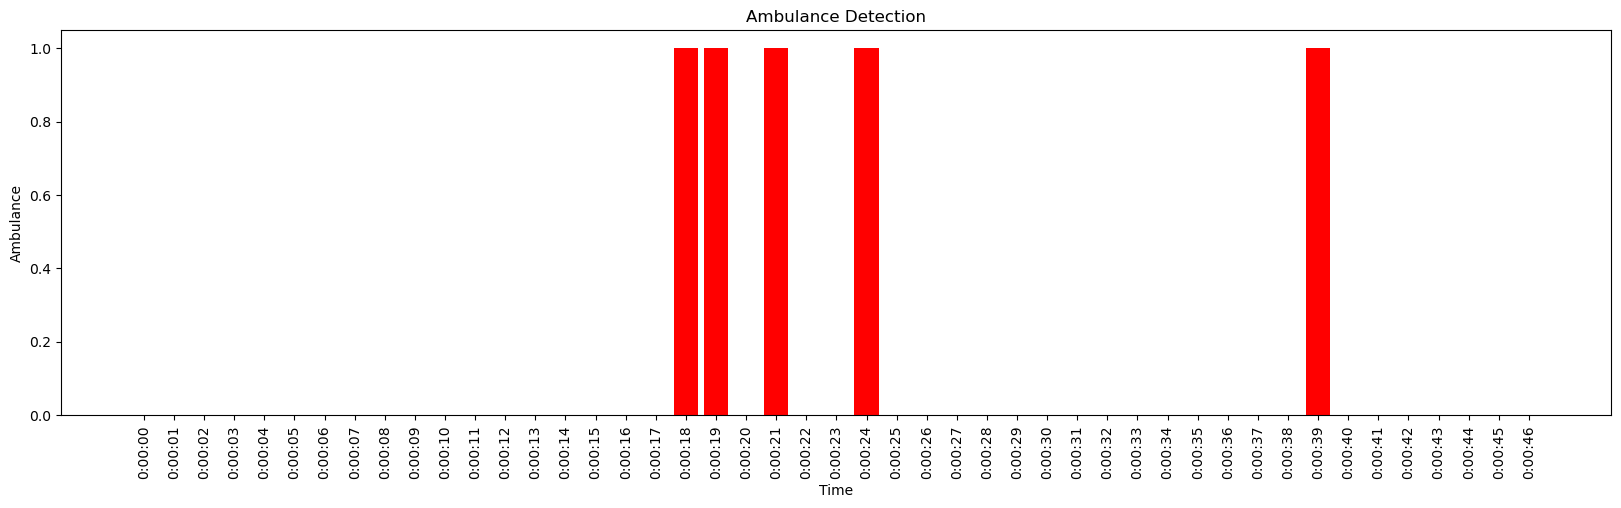

In [735]:
# Plot vertical bar chart where y is is_amblance and x is 'minute-th'
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['pred_ambulance'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()



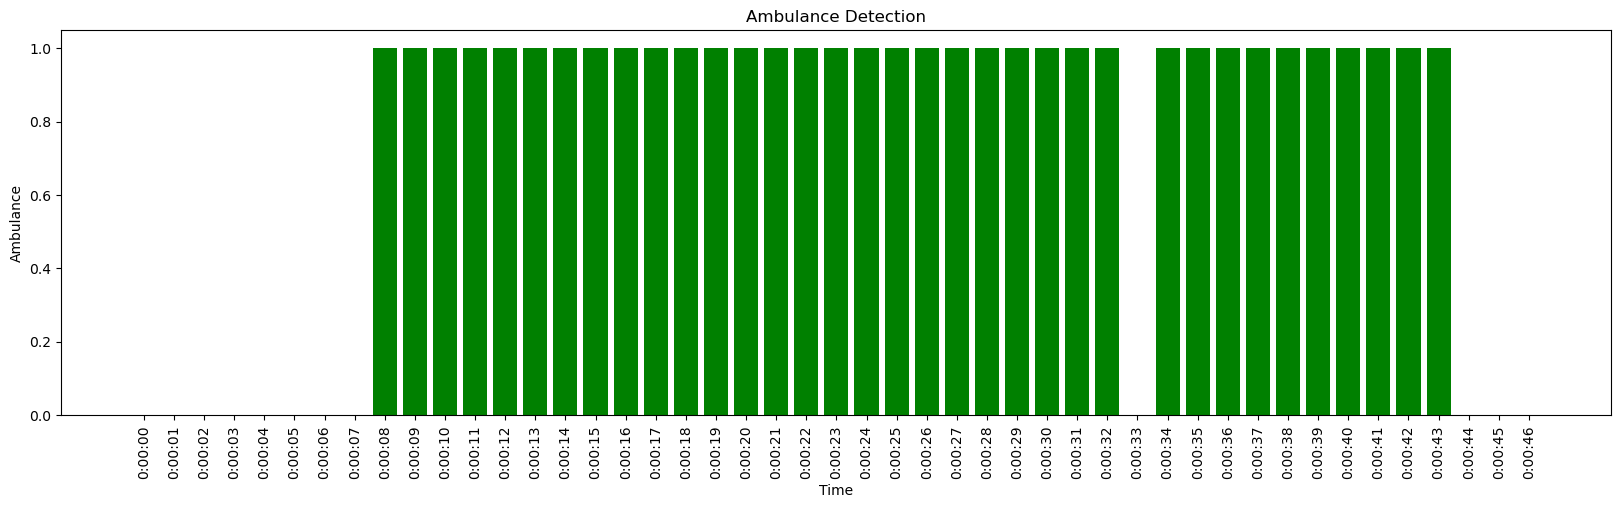

In [736]:
# Plot vertical bar chart where y is is_amblance and x is 'minute-th'
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['video_1'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

In [737]:
# setup confussion matrix
y_true = df['video_1']
y_pred = df['pred_ambulance']
cm =confusion_matrix(y_true, y_pred)

# accuracy, recall, precision, f1 score
accuracy = (cm[0][0] + cm[1][1]) / len(y_true)
recall = cm[1][1] / (cm[1][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1] + cm[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

print('accuracy:', accuracy)
print('recall:', recall)
print('precision:', precision)
print('f1_score:', f1_score)

accuracy: 0.3617021276595745
recall: 0.14285714285714285
precision: 1.0
f1_score: 0.25


Video 2

In [738]:
# Call test image for prediction for test video 2
folder_path_test = '../data/test_data/test_set2/'
files_test = [f for f in os.listdir(folder_path_test) if os.path.isfile(os.path.join(folder_path_test, f))]
filenames_test = []
for file in files_test:
    filenames_test.append(folder_path_test+file)


In [739]:
# Create list of filenames for prediction
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [740]:
# Create list of predictions
preds = []
for x in x_test:
    preds.append(model_3.predict(x))

1/1 [==============================] - 0s 187ms/step


In [741]:
# to overcome sorting issue
def extract_number(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# create dataframe to store filenames and predictions
df = pd.DataFrame(filenames_test, columns = ["filename"])
df = df.iloc[df['filename'].map(extract_number).argsort()]
df['Seconds'] = pd.Series([x for x in range(len(filenames_test))], index=df.index) # Add seconds column
df['Minute-th'] = pd.Series([convert(x) for x in df['Seconds']], index=df.index) # add time column 
df['Ambulance'] = pd.Series([preds[x][0][0] for x in range(len(preds))], index=df.index) # Add prediction prob for ambulance
df['prep_ambulance'] = np.where(df['Ambulance'] > 0.999, 1, 0)
df = df.join(df_result, on='Seconds')
df = df.drop(columns=['video_1', 'video_3', 'video_4'])
df


df

filename  Seconds Minute-th  Ambulance  \
0    ../data/test_data/test_set2/1.jpg        0   0:00:00   0.006312   
11   ../data/test_data/test_set2/2.jpg        1   0:00:01   0.928497   
22   ../data/test_data/test_set2/3.jpg        2   0:00:02   0.607970   
30   ../data/test_data/test_set2/4.jpg        3   0:00:03   0.622685   
31   ../data/test_data/test_set2/5.jpg        4   0:00:04   0.414547   
32   ../data/test_data/test_set2/6.jpg        5   0:00:05   0.005356   
33   ../data/test_data/test_set2/7.jpg        6   0:00:06   0.898415   
34   ../data/test_data/test_set2/8.jpg        7   0:00:07   0.971575   
35   ../data/test_data/test_set2/9.jpg        8   0:00:08   0.960666   
1   ../data/test_data/test_set2/10.jpg        9   0:00:09   0.889377   
2   ../data/test_data/test_set2/11.jpg       10   0:00:10   0.989205   
3   ../data/test_data/test_set2/12.jpg       11   0:00:11   0.225229   
4   ../data/test_data/test_set2/13.jpg       12   0:00:12   0.991431   
5   ../data/test_data/test_set2/14.jpg       13   0:00:13   0.996360   
6   ../data/test_data/test_set2/15.jpg       14   0:00:14   0.999038   
7   ../data/test_data/test_set2/16.jpg       15   0:00:15   0.999404   
8   ../data/test_data/test_set2/17.jpg       16   0:00:16   0.288584   
9   ../data/test_data/test_set2/18.jpg       17   0:00:17   0.999329   
10  ../data/test_data/test_set2/19.jpg       18   0:00:18   0.993089   
12  ../data/test_data/test_set2/20.jpg       19   0:00:19   0.980294   
13  ../data/test_data/test_set2/21.jpg       20   0:00:20   0.850149   
14  ../data/test_data/test_set2/22.jpg       21   0:00:21   0.637467   
15  ../data/test_data/test_set2/23.jpg       22   0:00:22   0.912000   
16  ../data/test_data/test_set2/24.jpg       23   0:00:23   0.705486   
17  ../data/test_data/test_set2/25.jpg       24   0:00:24   0.993320   
18  ../data/test_data/test_set2/26.jpg       25   0:00:25   0.993320   
19  ../data/test_data/test_set2/27.jpg       26   0:00:26   0.993320   
20  ../data/test_data/test_set2/28.jpg       27   0:00:27   0.993320   
21  ../data/test_data/test_set2/29.jpg       28   0:00:28   0.993320   
23  ../data/test_data/test_set2/30.jpg       29   0:00:29   0.993320   
24  ../data/test_data/test_set2/31.jpg       30   0:00:30   0.733539   
25  ../data/test_data/test_set2/32.jpg       31   0:00:31   0.926887   
26  ../data/test_data/test_set2/33.jpg       32   0:00:32   0.986848   
27  ../data/test_data/test_set2/34.jpg       33   0:00:33   0.991565   
28  ../data/test_data/test_set2/35.jpg       34   0:00:34   0.955089   
29  ../data/test_data/test_set2/36.jpg       35   0:00:35   0.876630   

    prep_ambulance  video_2  
0                0      0.0  
11               0      0.0  
22               0      0.0  
30               0      0.0  
31               0      0.0  
32               0      0.0  
33               0      0.0  
34               0      0.0  
35               0      0.0  
1                0      0.0  
2                0      0.0  
3                0      0.0  
4                0      0.0  
5                0      0.0  
6                1      0.0  
7                1      0.0  
8                0      0.0  
9                1      0.0  
10               0      0.0  
12               0      0.0  
13               0      0.0  
14               0      0.0  
15               0      0.0  
16               0      0.0  
17               0      0.0  
18               0      0.0  
19               0      0.0  
20               0      0.0  
21               0      0.0  
23               0      0.0  
24               0      0.0  
25               0      0.0  
26               0      0.0  
27               0      0.0  
28               0      0.0  
29               0      0.0

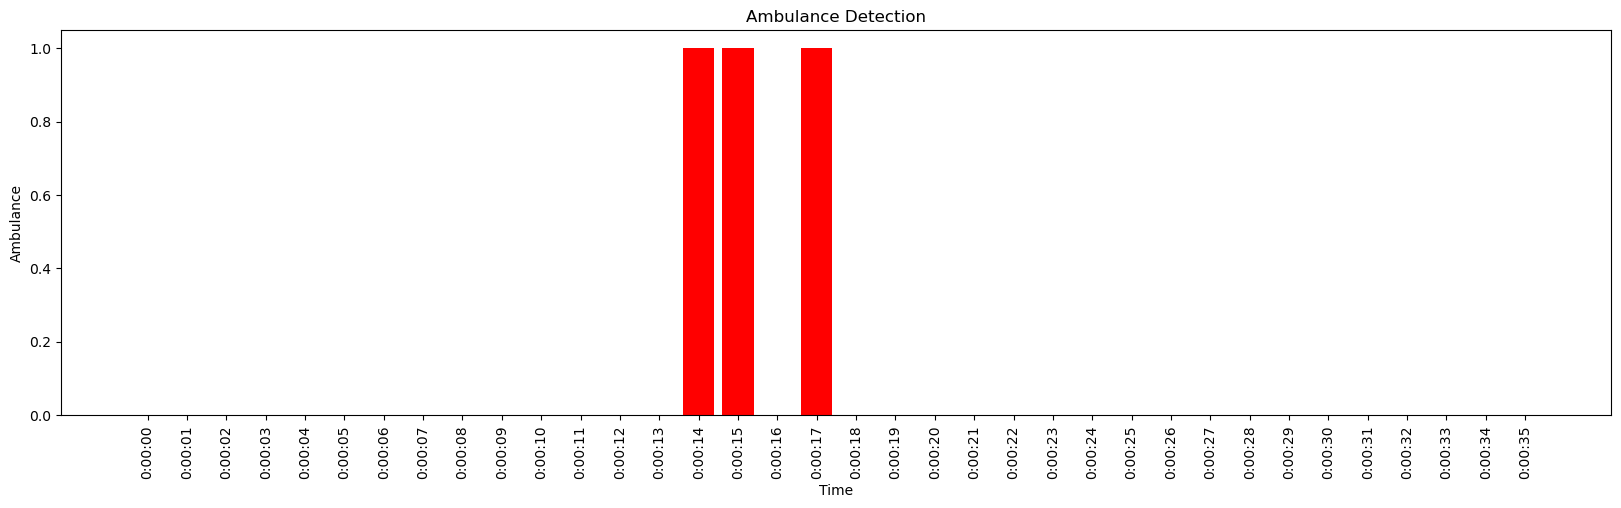

In [742]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['prep_ambulance'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

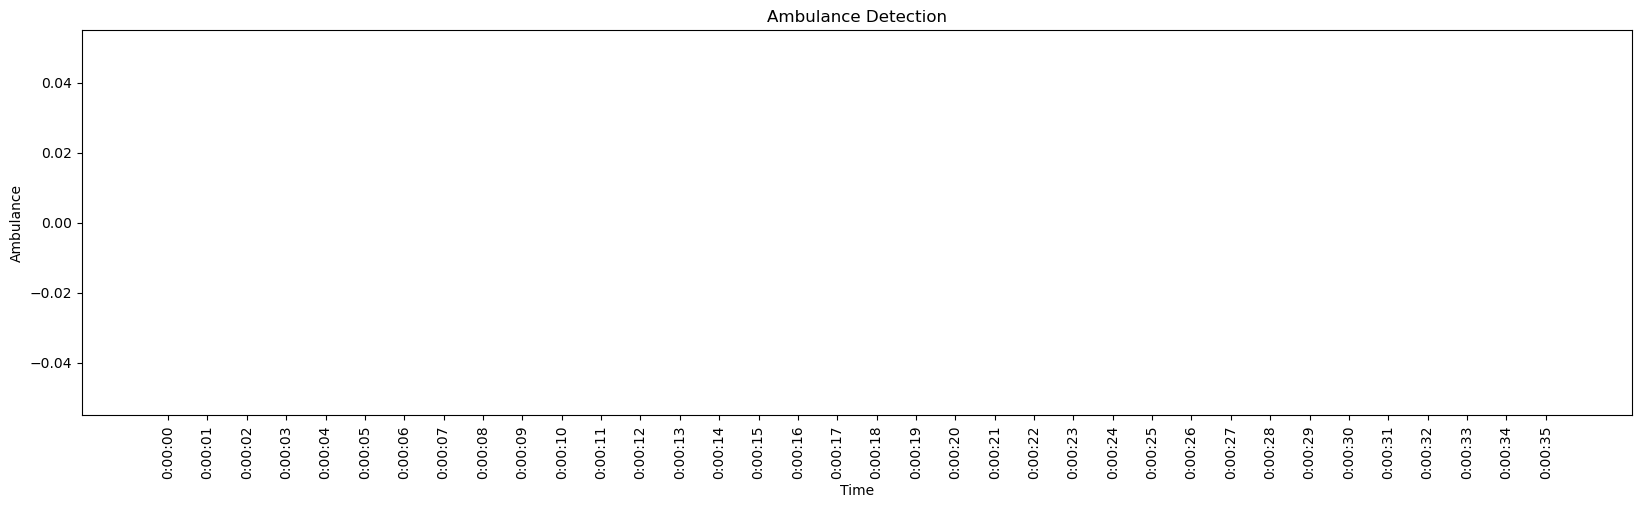

In [743]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['video_2'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

In [744]:
# setup confussion matrix
y_true = df['video_2']
y_pred = df['prep_ambulance']
cm =confusion_matrix(y_true, y_pred)

# accuracy, recall, precision, f1 score
accuracy = (cm[0][0] + cm[1][1]) / len(y_true)
recall = cm[1][1] / (cm[1][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1] + cm[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

print('accuracy:', accuracy)
print('recall:', recall)
print('precision:', precision)
print('f1_score:', f1_score)

accuracy: 0.9166666666666666
recall: nan
precision: 0.0
f1_score: nan


C:\Users\ponpa\AppData\Local\Temp\ipykernel_13540\3527623893.py:8: RuntimeWarning: invalid value encountered in scalar divide
  recall = cm[1][1] / (cm[1][1] + cm[1][0])


Video 3

In [764]:
# Call test image for prediction for test video 3
folder_path_test = '../data/test_data/test_set3/'
files_test = [f for f in os.listdir(folder_path_test) if os.path.isfile(os.path.join(folder_path_test, f))]
filenames_test = []
for file in files_test:
    filenames_test.append(folder_path_test+file)

In [765]:
# Create list of filenames for prediction
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [766]:
# Create list of predictions
preds = []
for x in x_test:
    preds.append(model_3.predict(x))

1/1 [==============================] - 0s 190ms/step


In [767]:
# to overcome sorting issue
def extract_number(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# create dataframe to store filenames and predictions
df = pd.DataFrame(filenames_test, columns = ["filename"])
df = df.iloc[df['filename'].map(extract_number).argsort()]
df['Seconds'] = pd.Series([x for x in range(len(filenames_test))], index=df.index) # Add seconds column
df['Minute-th'] = pd.Series([convert(x) for x in df['Seconds']], index=df.index) # add time column 
df['Ambulance'] = pd.Series([preds[x][0][0] for x in range(len(preds))], index=df.index) # Add prediction prob for ambulance
df['pred_ambulance'] = np.where(df['Ambulance'] > 0.9, 1, 0)
df = df.join(df_result, on='Seconds')
df = df.drop(columns=['video_1', 'video_2', 'video_4'])
df

filename  Seconds Minute-th  Ambulance  \
0    ../data/test_data/test_set3/1.jpg        0   0:00:00   0.008473   
11   ../data/test_data/test_set3/2.jpg        1   0:00:01   0.410837   
22   ../data/test_data/test_set3/3.jpg        2   0:00:02   0.438381   
28   ../data/test_data/test_set3/4.jpg        3   0:00:03   0.399468   
29   ../data/test_data/test_set3/5.jpg        4   0:00:04   0.239789   
30   ../data/test_data/test_set3/6.jpg        5   0:00:05   0.066062   
31   ../data/test_data/test_set3/7.jpg        6   0:00:06   0.086023   
32   ../data/test_data/test_set3/8.jpg        7   0:00:07   0.166800   
33   ../data/test_data/test_set3/9.jpg        8   0:00:08   0.228140   
1   ../data/test_data/test_set3/10.jpg        9   0:00:09   0.215071   
2   ../data/test_data/test_set3/11.jpg       10   0:00:10   0.171932   
3   ../data/test_data/test_set3/12.jpg       11   0:00:11   0.011597   
4   ../data/test_data/test_set3/13.jpg       12   0:00:12   0.493836   
5   ../data/test_data/test_set3/14.jpg       13   0:00:13   0.353808   
6   ../data/test_data/test_set3/15.jpg       14   0:00:14   0.988705   
7   ../data/test_data/test_set3/16.jpg       15   0:00:15   0.769916   
8   ../data/test_data/test_set3/17.jpg       16   0:00:16   0.771272   
9   ../data/test_data/test_set3/18.jpg       17   0:00:17   0.222207   
10  ../data/test_data/test_set3/19.jpg       18   0:00:18   0.709325   
12  ../data/test_data/test_set3/20.jpg       19   0:00:19   0.489567   
13  ../data/test_data/test_set3/21.jpg       20   0:00:20   0.958508   
14  ../data/test_data/test_set3/22.jpg       21   0:00:21   0.719680   
15  ../data/test_data/test_set3/23.jpg       22   0:00:22   0.007695   
16  ../data/test_data/test_set3/24.jpg       23   0:00:23   0.908976   
17  ../data/test_data/test_set3/25.jpg       24   0:00:24   0.922081   
18  ../data/test_data/test_set3/26.jpg       25   0:00:25   0.922081   
19  ../data/test_data/test_set3/27.jpg       26   0:00:26   0.922081   
20  ../data/test_data/test_set3/28.jpg       27   0:00:27   0.922081   
21  ../data/test_data/test_set3/29.jpg       28   0:00:28   0.091749   
23  ../data/test_data/test_set3/30.jpg       29   0:00:29   0.205396   
24  ../data/test_data/test_set3/31.jpg       30   0:00:30   0.328125   
25  ../data/test_data/test_set3/32.jpg       31   0:00:31   0.217888   
26  ../data/test_data/test_set3/33.jpg       32   0:00:32   0.151194   
27  ../data/test_data/test_set3/34.jpg       33   0:00:33   0.161398   

    pred_ambulance  video_3  
0                0      0.0  
11               0      0.0  
22               0      0.0  
28               0      0.0  
29               0      0.0  
30               0      0.0  
31               0      0.0  
32               0      0.0  
33               0      0.0  
1                0      0.0  
2                0      0.0  
3                0      0.0  
4                0      0.0  
5                0      0.0  
6                1      0.0  
7                0      0.0  
8                0      0.0  
9                0      0.0  
10               0      0.0  
12               0      0.0  
13               1      0.0  
14               0      0.0  
15               0      1.0  
16               1      1.0  
17               1      1.0  
18               1      0.0  
19               1      0.0  
20               1      0.0  
21               0      0.0  
23               0      0.0  
24               0      0.0  
25               0      0.0  
26               0      0.0  
27               0      0.0

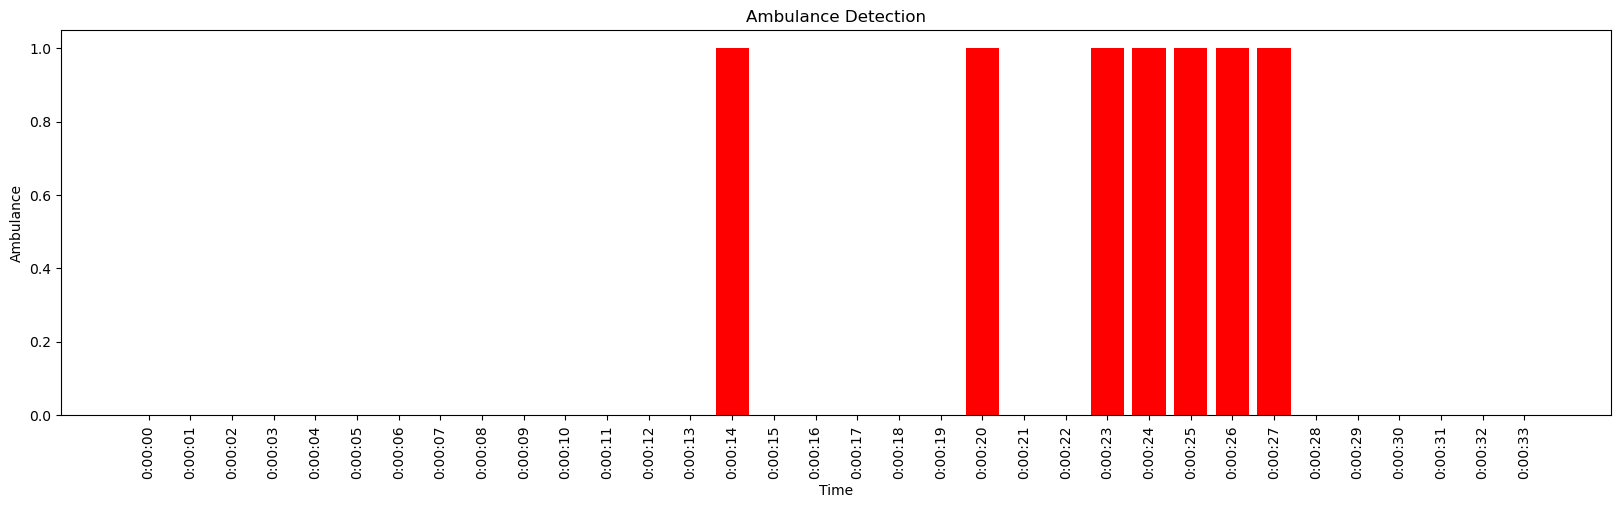

In [749]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['pred_ambulance'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

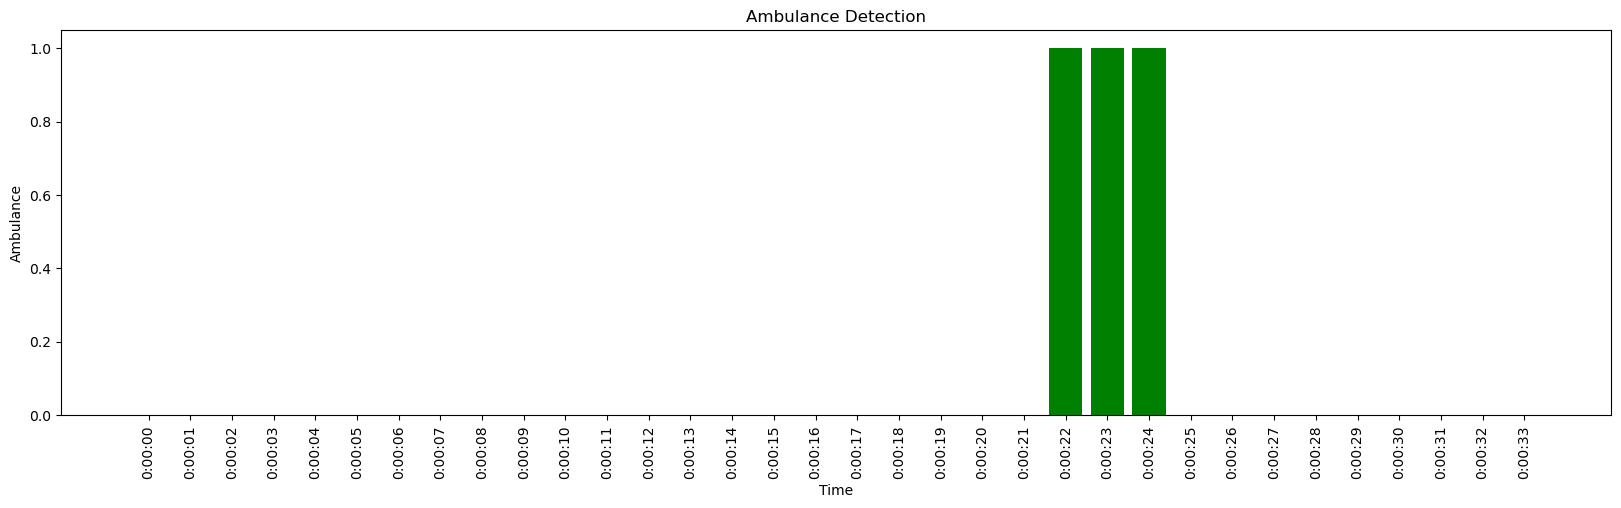

In [750]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['video_3'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

In [768]:
# setup confussion matrix
y_true = df['video_3']
y_pred = df['pred_ambulance']
cm =confusion_matrix(y_true, y_pred)
# accuracy, recall, precision, f1 score
accuracy = (cm[0][0] + cm[1][1]) / len(y_true)
recall = cm[1][1] / (cm[1][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1] + cm[0][1])
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

print('accuracy:', accuracy)
print('recall:', recall)
print('precision:', precision)
print('specificity:', specificity)
print('f1_score:', f1_score)

accuracy: 0.8235294117647058
recall: 0.6666666666666666
precision: 0.2857142857142857
specificity: 0.8387096774193549
f1_score: 0.4


Video 4

In [752]:
# Call test image for prediction for test video 4
folder_path_test = '../data/test_data/test_set4/'
files_test = [f for f in os.listdir(folder_path_test) if os.path.isfile(os.path.join(folder_path_test, f))]
filenames_test = []
for file in files_test:
    filenames_test.append(folder_path_test+file)

In [753]:
# Create list of filenames for prediction
x_test = []
for x in filenames_test:
    img = image.load_img(x, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x_test.append(x)

In [754]:
# Create list of predictions
preds = []
for x in x_test:
    preds.append(model_3.predict(x))

1/1 [==============================] - 0s 158ms/step


In [755]:
# to overcome sorting issue
def extract_number(file_name):
    return int(''.join(filter(str.isdigit, file_name)))

# create dataframe to store filenames and predictions
df = pd.DataFrame(filenames_test, columns = ["filename"])
df = df.iloc[df['filename'].map(extract_number).argsort()]
df['Seconds'] = pd.Series([x for x in range(len(filenames_test))], index=df.index) # Add seconds column
df['Minute-th'] = pd.Series([convert(x) for x in df['Seconds']], index=df.index) # add time column 
df['Ambulance'] = pd.Series([preds[x][0][0] for x in range(len(preds))], index=df.index) # Add prediction prob for ambulance
df['pred_ambulance'] = np.where(df['Ambulance'] > 0.99, 1, 0)
df = df.join(df_result, on='Seconds')
df = df.drop(columns=['video_1', 'video_2', 'video_3'])
df

filename  Seconds Minute-th  Ambulance  \
0    ../data/test_data/test_set4/1.jpg        0   0:00:00   0.017999   
11   ../data/test_data/test_set4/2.jpg        1   0:00:01   0.701601   
22   ../data/test_data/test_set4/3.jpg        2   0:00:02   0.819808   
33   ../data/test_data/test_set4/4.jpg        3   0:00:03   0.951781   
34   ../data/test_data/test_set4/5.jpg        4   0:00:04   0.963025   
35   ../data/test_data/test_set4/6.jpg        5   0:00:05   0.772180   
36   ../data/test_data/test_set4/7.jpg        6   0:00:06   0.762392   
37   ../data/test_data/test_set4/8.jpg        7   0:00:07   0.835232   
38   ../data/test_data/test_set4/9.jpg        8   0:00:08   0.735269   
1   ../data/test_data/test_set4/10.jpg        9   0:00:09   0.682908   
2   ../data/test_data/test_set4/11.jpg       10   0:00:10   0.538819   
3   ../data/test_data/test_set4/12.jpg       11   0:00:11   0.014831   
4   ../data/test_data/test_set4/13.jpg       12   0:00:12   0.997173   
5   ../data/test_data/test_set4/14.jpg       13   0:00:13   0.670189   
6   ../data/test_data/test_set4/15.jpg       14   0:00:14   0.806260   
7   ../data/test_data/test_set4/16.jpg       15   0:00:15   0.476358   
8   ../data/test_data/test_set4/17.jpg       16   0:00:16   0.825126   
9   ../data/test_data/test_set4/18.jpg       17   0:00:17   0.090563   
10  ../data/test_data/test_set4/19.jpg       18   0:00:18   0.705790   
12  ../data/test_data/test_set4/20.jpg       19   0:00:19   0.939549   
13  ../data/test_data/test_set4/21.jpg       20   0:00:20   0.861821   
14  ../data/test_data/test_set4/22.jpg       21   0:00:21   0.689536   
15  ../data/test_data/test_set4/23.jpg       22   0:00:22   0.248708   
16  ../data/test_data/test_set4/24.jpg       23   0:00:23   0.848678   
17  ../data/test_data/test_set4/25.jpg       24   0:00:24   0.006252   
18  ../data/test_data/test_set4/26.jpg       25   0:00:25   0.116539   
19  ../data/test_data/test_set4/27.jpg       26   0:00:26   0.753477   
20  ../data/test_data/test_set4/28.jpg       27   0:00:27   0.089795   
21  ../data/test_data/test_set4/29.jpg       28   0:00:28   0.097767   
23  ../data/test_data/test_set4/30.jpg       29   0:00:29   0.233701   
24  ../data/test_data/test_set4/31.jpg       30   0:00:30   0.233701   
25  ../data/test_data/test_set4/32.jpg       31   0:00:31   0.233701   
26  ../data/test_data/test_set4/33.jpg       32   0:00:32   0.233701   
27  ../data/test_data/test_set4/34.jpg       33   0:00:33   0.222286   
28  ../data/test_data/test_set4/35.jpg       34   0:00:34   0.055663   
29  ../data/test_data/test_set4/36.jpg       35   0:00:35   0.024155   
30  ../data/test_data/test_set4/37.jpg       36   0:00:36   0.039713   
31  ../data/test_data/test_set4/38.jpg       37   0:00:37   0.178670   
32  ../data/test_data/test_set4/39.jpg       38   0:00:38   0.410818   

    pred_ambulance  video_4  
0                0      0.0  
11               0      0.0  
22               0      0.0  
33               0      0.0  
34               0      0.0  
35               0      0.0  
36               0      0.0  
37               0      0.0  
38               0      0.0  
1                0      0.0  
2                0      0.0  
3                0      0.0  
4                1      0.0  
5                0      0.0  
6                0      0.0  
7                0      0.0  
8                0      0.0  
9                0      0.0  
10               0      0.0  
12               0      0.0  
13               0      0.0  
14               0      0.0  
15               0      1.0  
16               0      0.0  
17               0      0.0  
18               0      0.0  
19               0      0.0  
20               0      0.0  
21               0      0.0  
23               0      0.0  
24               0      0.0  
25               0      0.0  
26               0      0.0  
27               0      0.0  
28               0      0.0  
29               0      0.0  
30               0      0.0  
31       

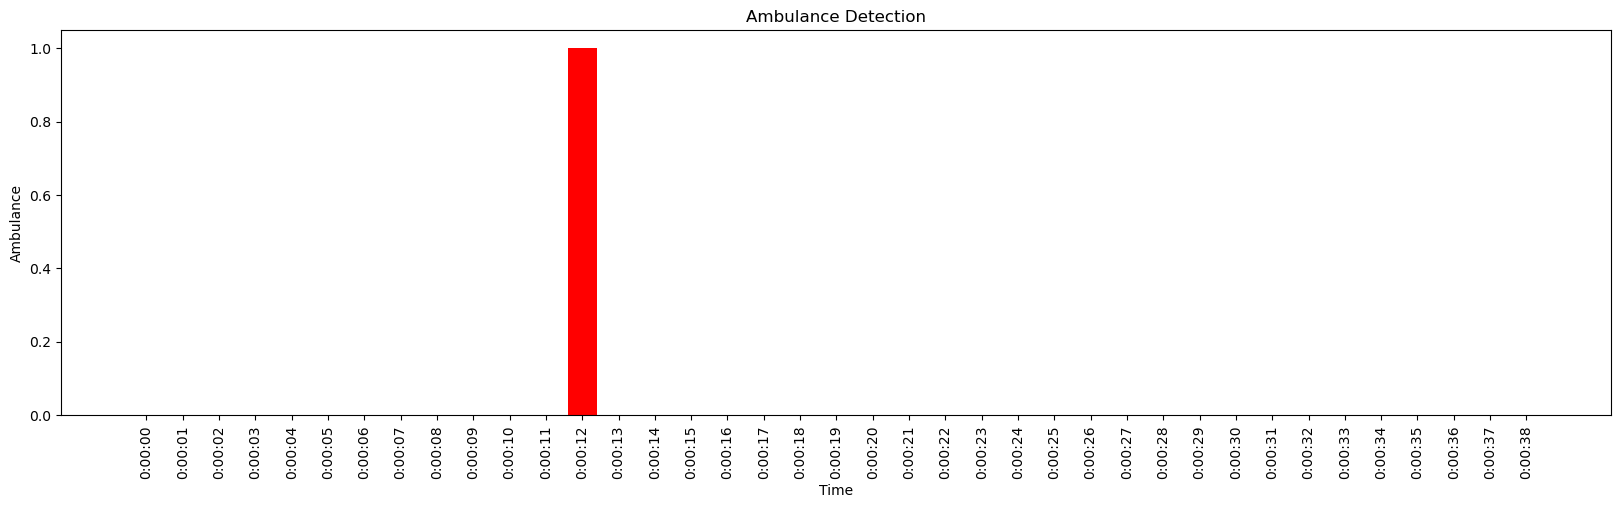

In [756]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['pred_ambulance'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

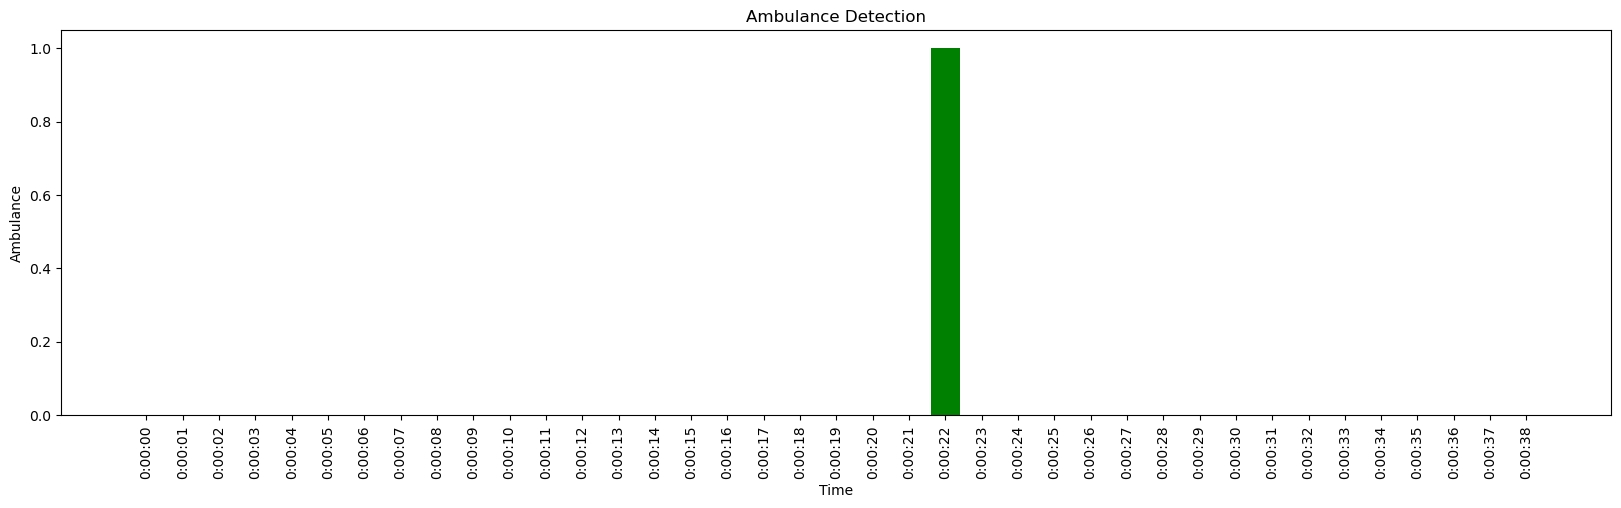

In [757]:
plt.figure(figsize=(20,5))
plt.bar(df['Minute-th'], df['video_4'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Ambulance')
plt.title('Ambulance Detection')
plt.show()

In [762]:
# setup confussion matrix
y_true = df['video_4']
y_pred = df['pred_ambulance']
cm =confusion_matrix(y_true, y_pred)
# accuracy, recall, precision, f1 score
accuracy = (cm[0][0] + cm[1][1]) / len(y_true)
recall = cm[1][1] / (cm[1][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1] + cm[0][1])
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

print('accuracy:', accuracy)
print('recall:', recall)
print('precision:', precision)
print('specificity:', specificity)
print('f1_score:', f1_score)   
specificity = cm[0][0] / (cm[0][0] + cm[0][1])

accuracy: 0.9487179487179487
recall: 0.0
precision: 0.0
specificity: 0.9736842105263158
f1_score: nan


C:\Users\ponpa\AppData\Local\Temp\ipykernel_13540\3855485509.py:10: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)


Result